In [1]:
import GPy
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import ToUndirected
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import to_undirected
from torch_geometric_temporal.signal import temporal_signal_split
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'


warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [2]:
D = 2

kernel = GPy.kern.RBF(input_dim=D, variance=1, lengthscale=0.8)

# Define the grid
w1 = np.linspace(-3, 3, 50)
w2 = np.linspace(-3, 3, 50)
W1, W2 = np.meshgrid(w1, w2)
W1_flat = W1.reshape(-1, 1)
W2_flat = W2.reshape(-1, 1)
X = np.hstack((W1_flat, W2_flat))
y = np.random.multivariate_normal(np.zeros(2500), kernel.K(X)).reshape(50, 50)


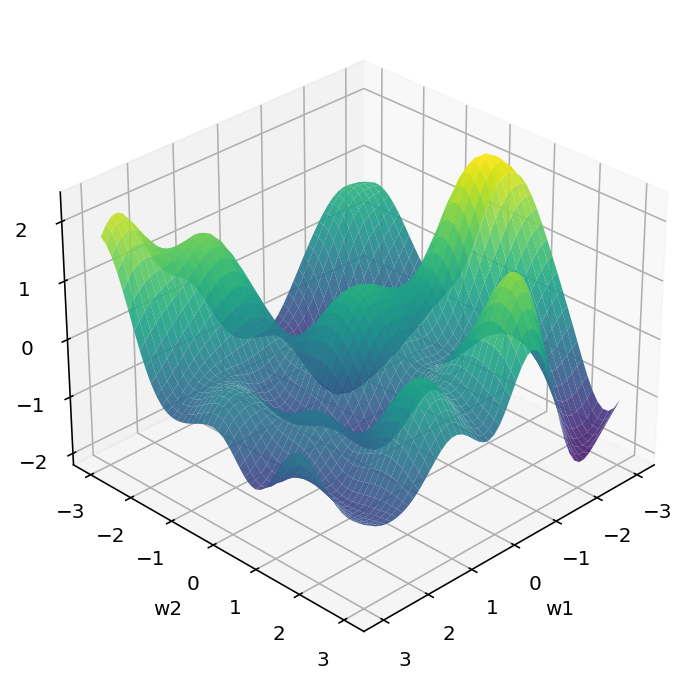

In [3]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, y, cmap="viridis", alpha=0.9)
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.view_init(30, 45)
plt.show()

In [4]:
# w1 = StandardScaler().fit_transform(w1.reshape(-1, 1))
# w2 = StandardScaler().fit_transform(w2.reshape(-1, 1))

# matrix = y

# # Create an instance of StandardScaler
# scaler = StandardScaler()

# # Flatten the matrix to a 1D array
# matrix_flattened = matrix.flatten()

# # Fit the scaler to the flattened matrix data
# scaler.fit(matrix_flattened.reshape(-1, 1))

# # Transform the matrix using the scaler
# normalized_matrix = scaler.transform(matrix_flattened.reshape(-1, 1))

# # Reshape the normalized matrix back to its original shape
# normalized_matrix = normalized_matrix.reshape(matrix.shape)

# y = normalized_matrix

Create graph with: 
- w1 as x 
- w2 as time 
- y as target

In [5]:
def get_distance(x1, x2):
    return abs(x1 - x2)

def spatial_graph(w1, y, time):

    # Create an empty graph
    G = nx.Graph()

    for i in range(len(w1)):
        x = w1[i]
        target = y[i]
        G.add_node(i+time, x = x, y = target)
        
        for j in range(i+1, i+5):
            if j >= len(w1):
                break
         
            xj = w1[j]
            yj = y[j]
            G.add_edge(i+time, j+time)
    
    return G

In [6]:
def generate_graph(w1, w2, y):
    
    #initialize empty graph
    G = nx.Graph()
    
    #loop over all the timestamps
    for i in range(len(w2)):
        
        #Create Spatial Graph for this timestamp
        G_i = spatial_graph(w1, y[i], i*50)
        
        #Add this graph to the overall graph
        G = nx.compose(G, G_i)
        
        #add temporal edges for each station
        for j in range(len(w1)):
            curr_node = i*50 + j

            for time_edge in range(i-1, i-4, -1):
                if time_edge < 0:
                    break
                prev_node = time_edge*50 + j
                G.add_edge(curr_node, prev_node)

        
    return G
        

In [7]:
G = generate_graph(w1, w2, y)

In [8]:
node_features = [[(G.nodes[node]['x'])] for node in G.nodes]

edge_weights = []
undirected_edges = []
for edge in G.edges:
    undirected_edges.append(edge)
    undirected_edges.append((edge[1], edge[0]))  # Add the reverse edge
#     edge_weights.append(G.get_edge_data(edge[0], edge[1])['weight'])
#     edge_weights.append(G.get_edge_data(edge[1], edge[0])['weight'])

edge_index = torch.tensor(undirected_edges).t().contiguous()
edge_weights = torch.tensor(edge_weights).t().contiguous()
y = torch.tensor([G.nodes[node]['y'] for node in G.nodes], dtype=torch.float).view(-1, 1)
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

n_train = int(0.75*len(G.nodes))
n_train -= n_train%50

train_mask[:n_train] = True
test_mask[n_train:] = True

data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, edge_weights = edge_weights, y=y,train_mask=train_mask, test_mask=test_mask).to(device)

In [9]:
class InitialEmbedding(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 32)
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
  

class PredictionLayer(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 32)
        self.linear2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
        
class MainModel(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.mlp1 = InitialEmbedding(input_dim)
        self.conv1 = GCNConv(32, 32)
        self.conv2 = GCNConv(64, 32)
        self.mlp2 = PredictionLayer(64)
        self.dropout = nn.Dropout(p = 0.5)
        
    def forward(self, x, edge_index):
        #Initial Embedding
        h0 = self.mlp1(x)
        
        #First GCN Layer
        h1 = self.conv1(h0, edge_index)
        h1 = F.relu(h1)
        h1 = self.dropout(h1)
        h1 = torch.cat([h1, h0], dim = 1)
        
        #Second GCN Layer
        h2 = self.conv2(h1, edge_index)
        h2 = F.relu(h2)
        h2 = self.dropout(h2)
        h2 = torch.cat([h2, h0], dim = 1)
        
        #Prediction Layer
        output = self.mlp2(h2)
        
        return output

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:44<00:00, 28.58it/s]


Train RMSE: 0.82661
Test RMSE: 1.009583


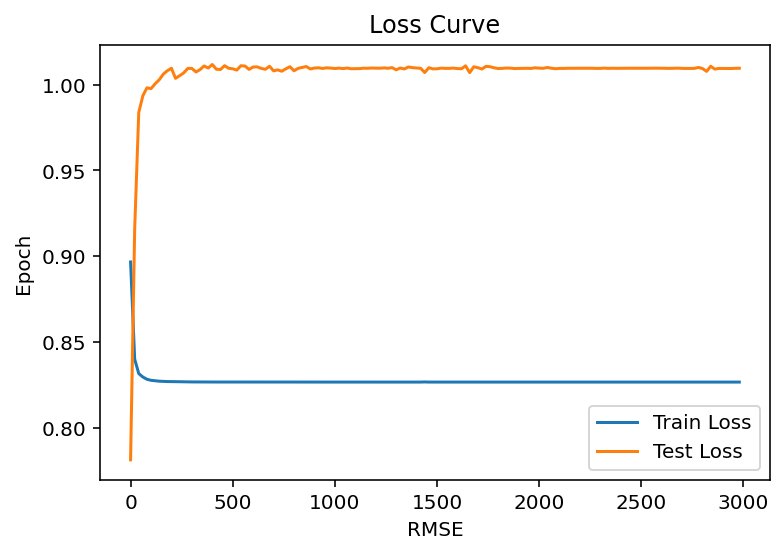

In [10]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MainModel(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(3000)):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print("Train RMSE:", train_rmse.numpy())
    print("Test RMSE:", test_rmse.numpy())

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [11]:
preds = out[data.test_mask].squeeze().detach()
actual = data.y[data.test_mask].squeeze()

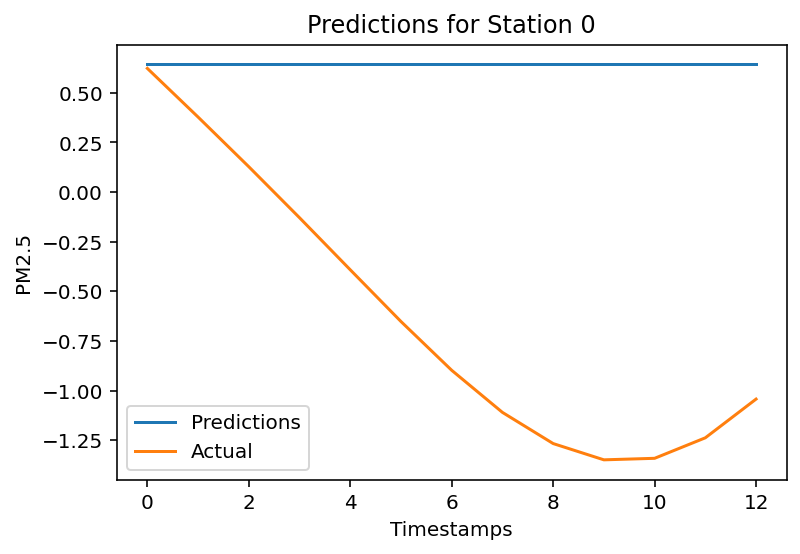

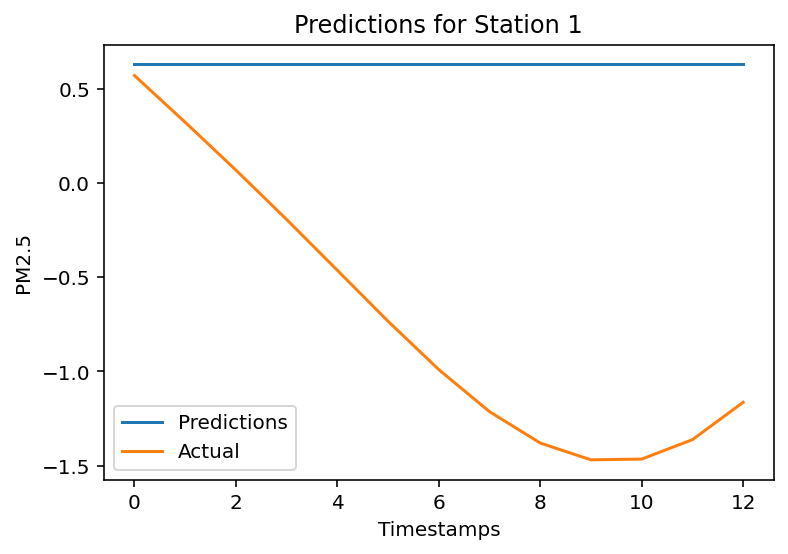

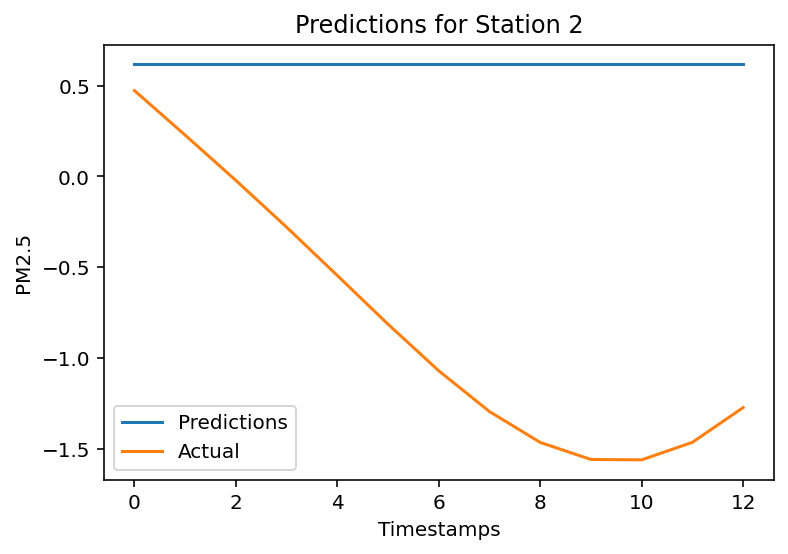

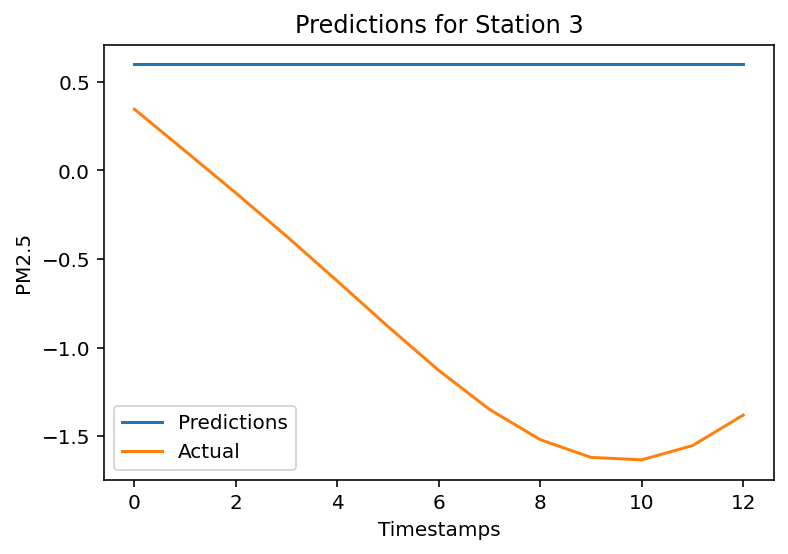

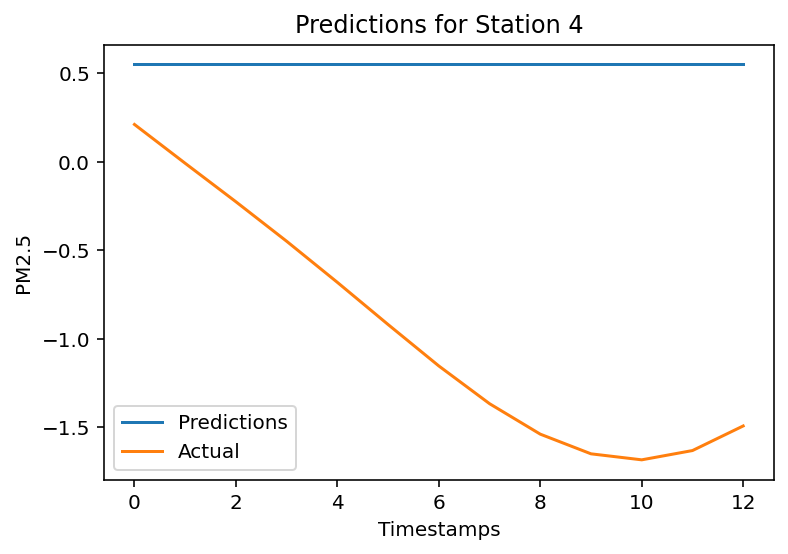

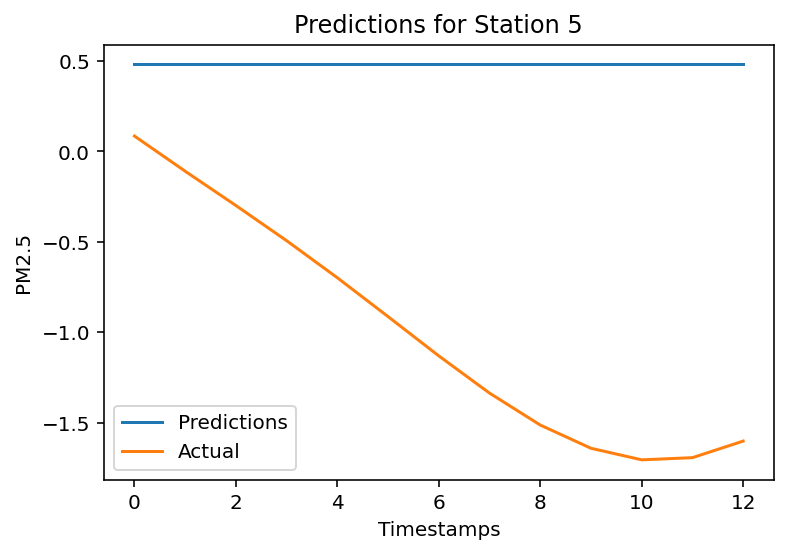

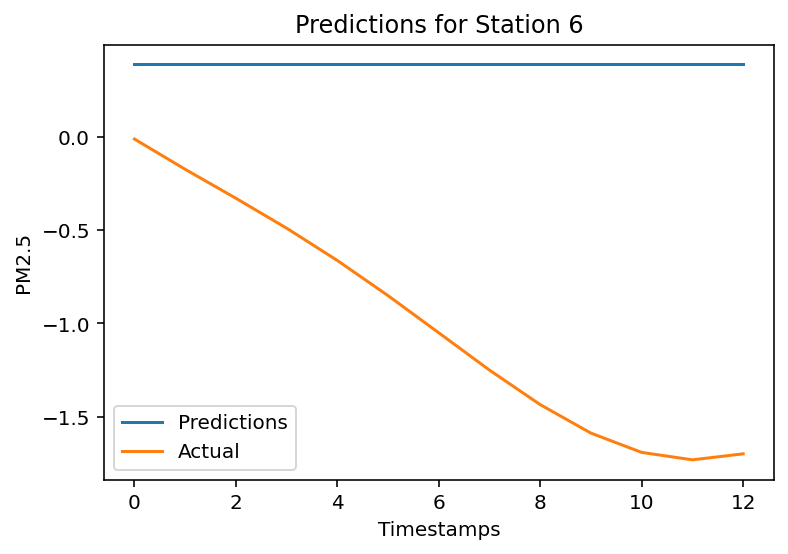

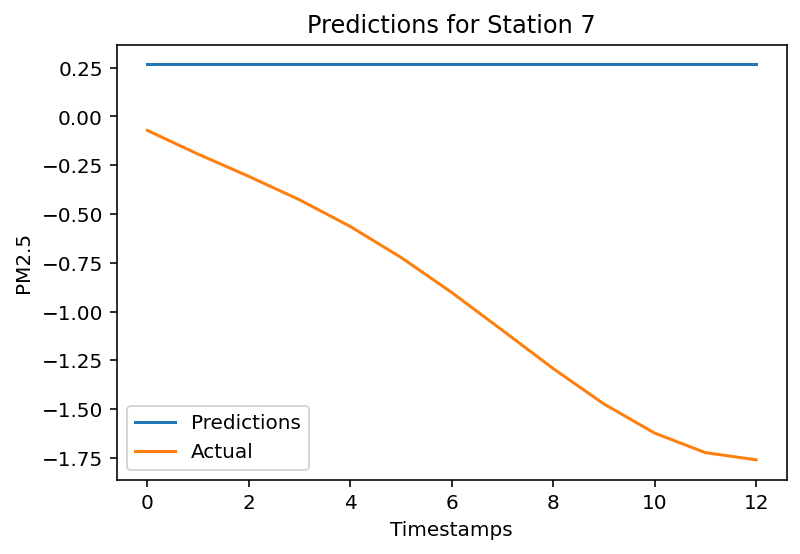

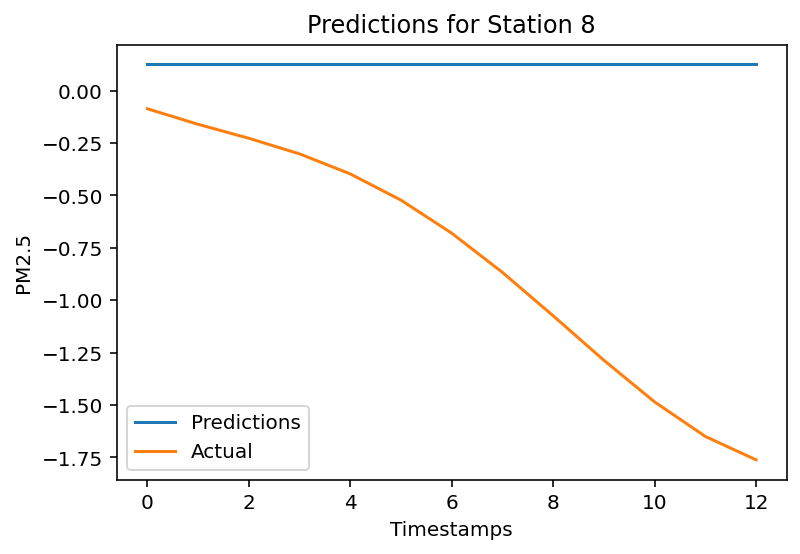

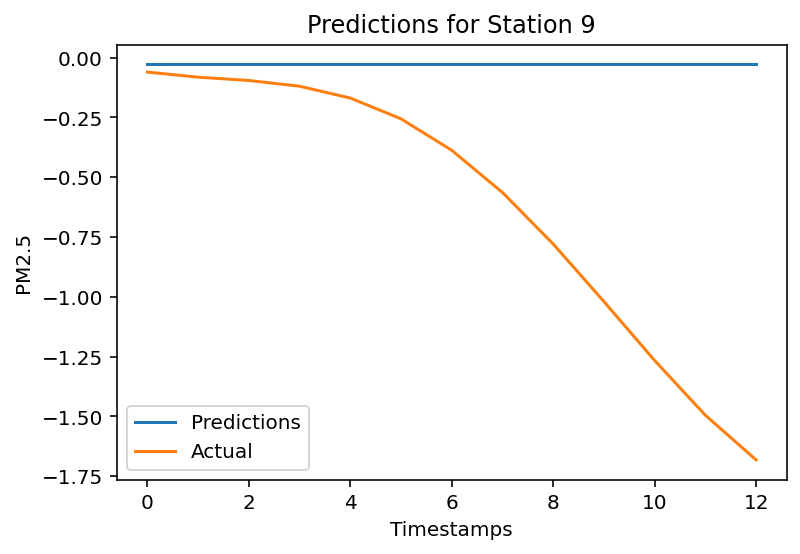

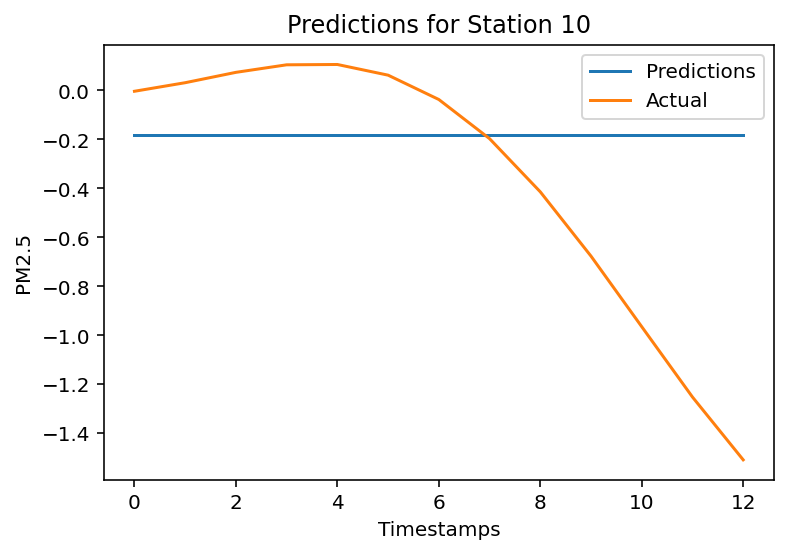

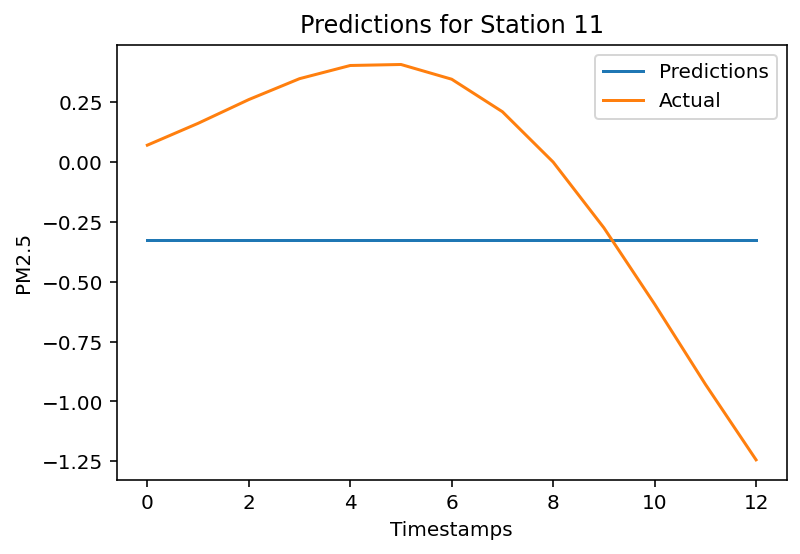

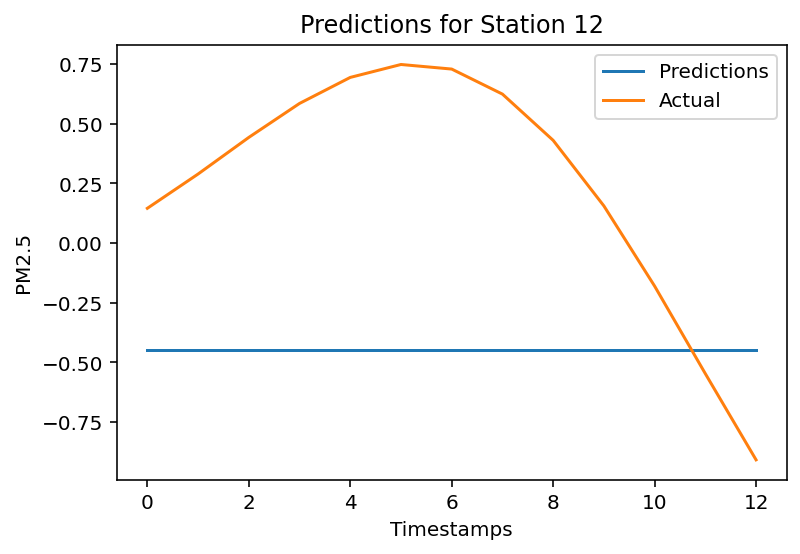

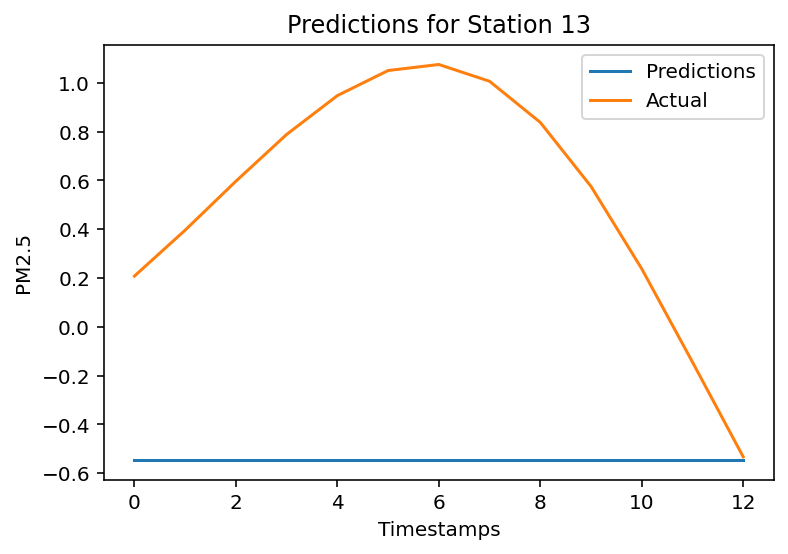

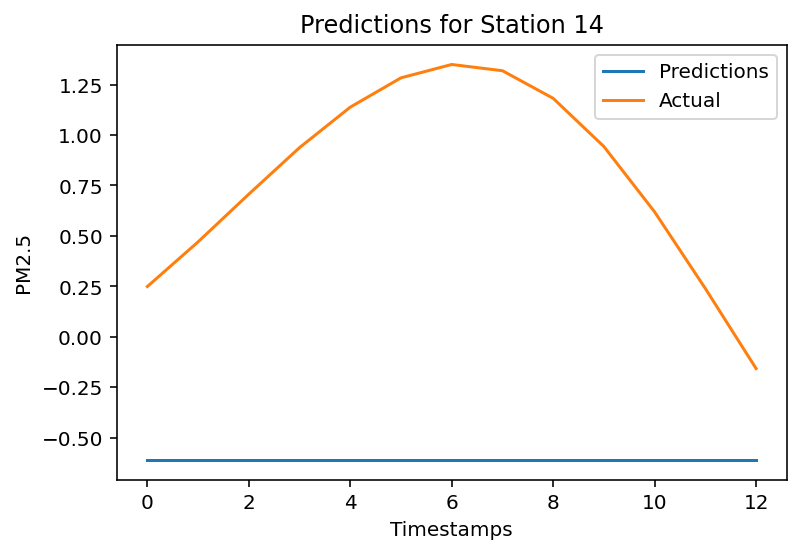

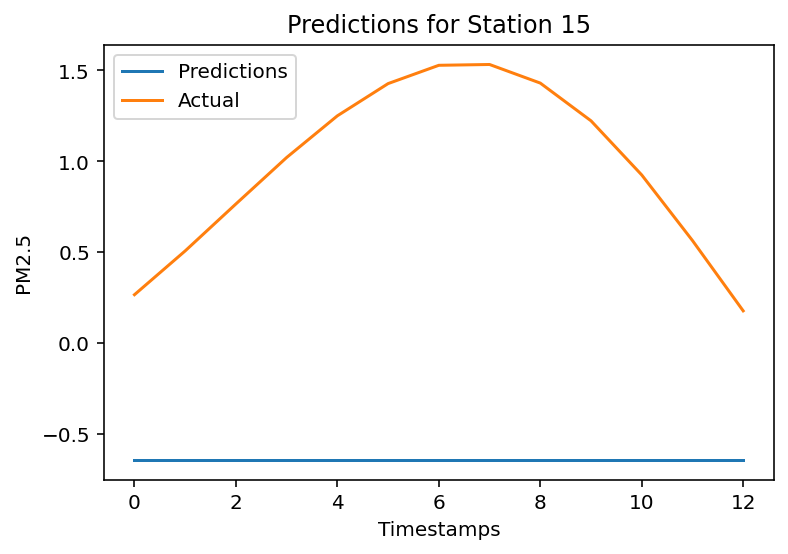

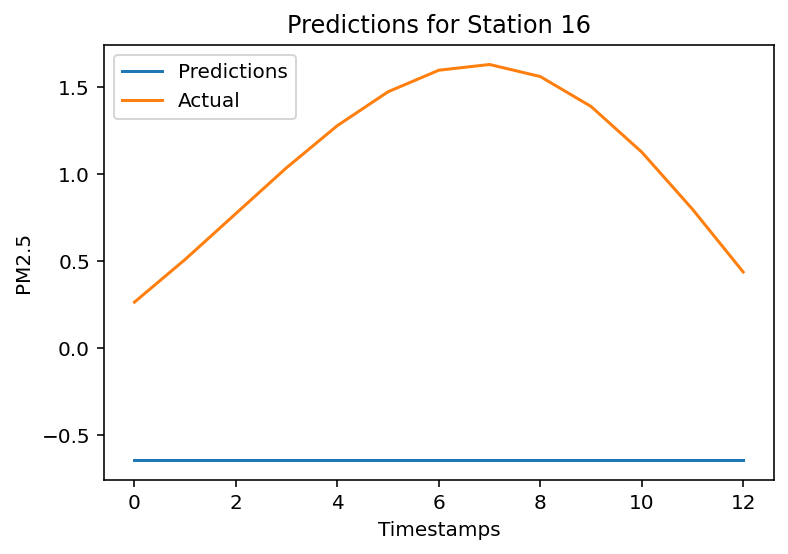

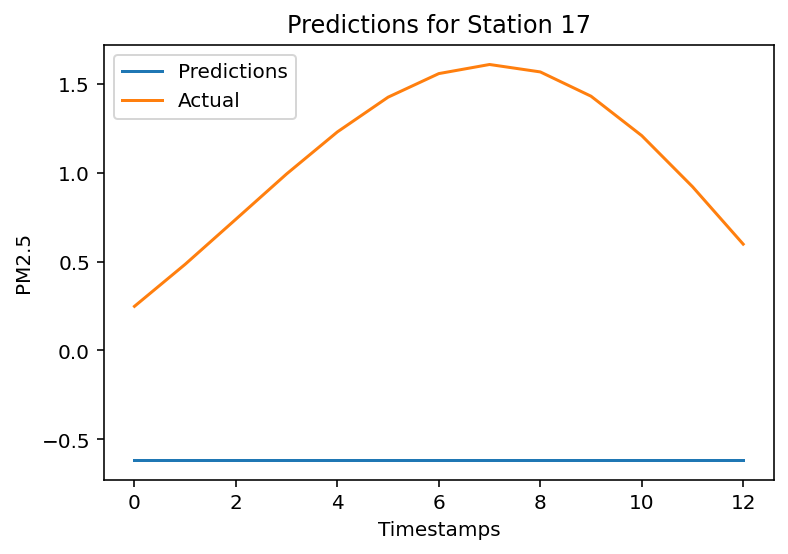

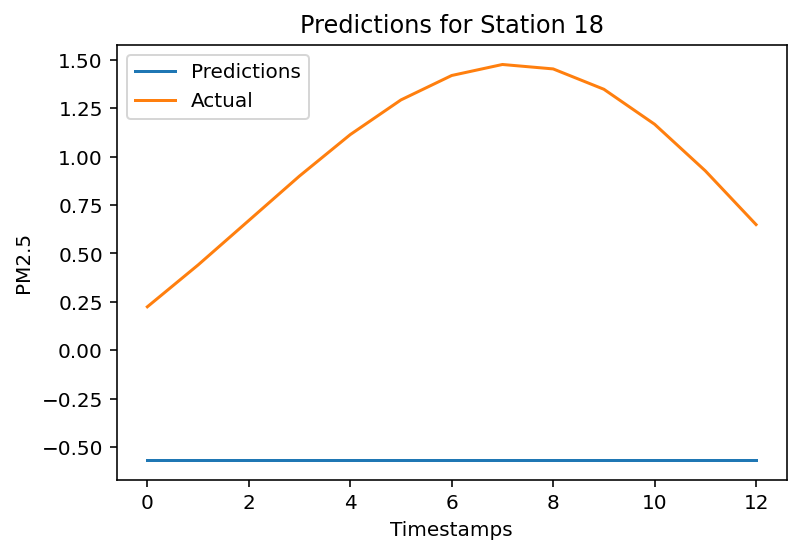

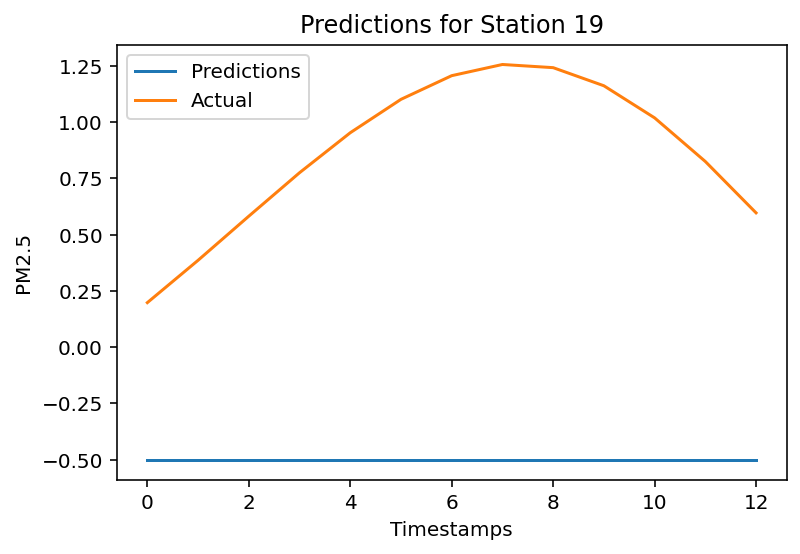

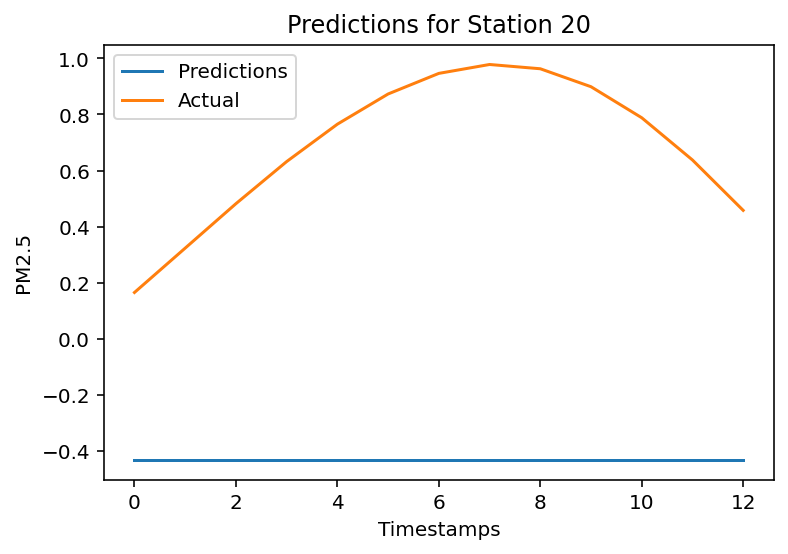

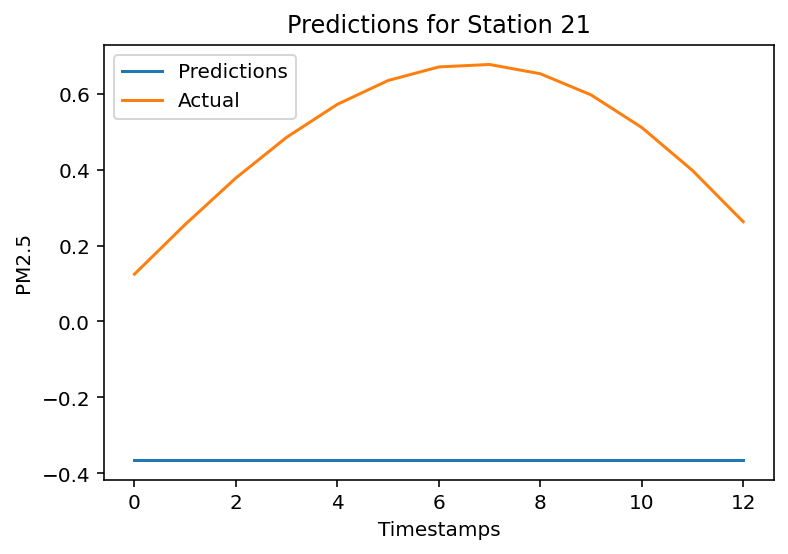

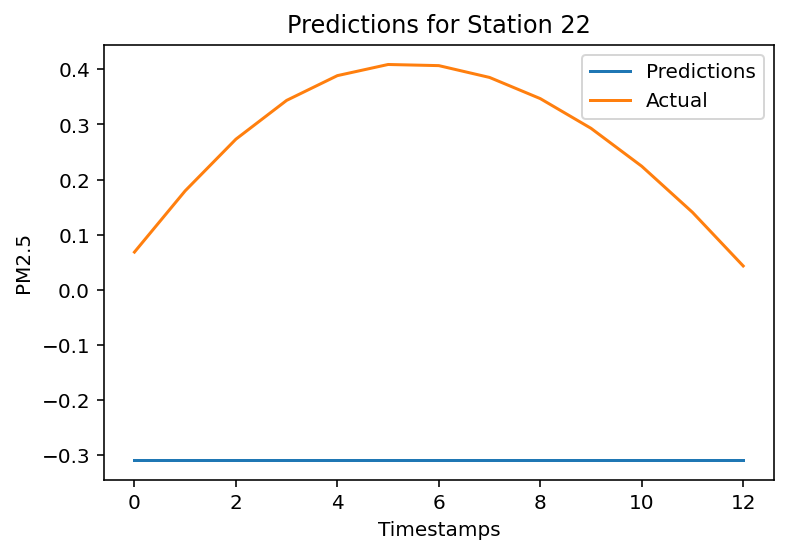

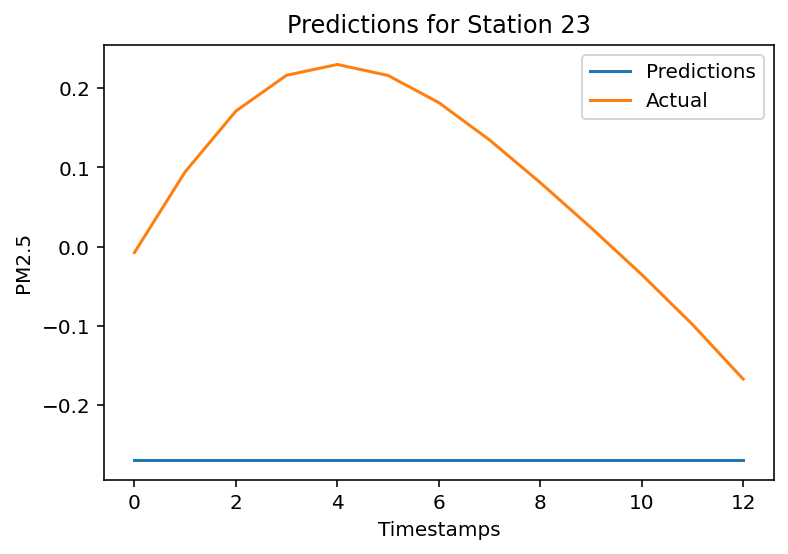

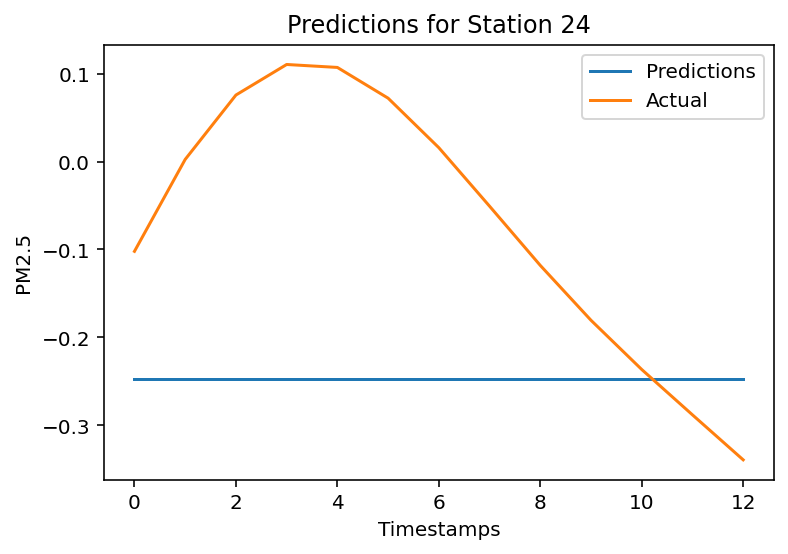

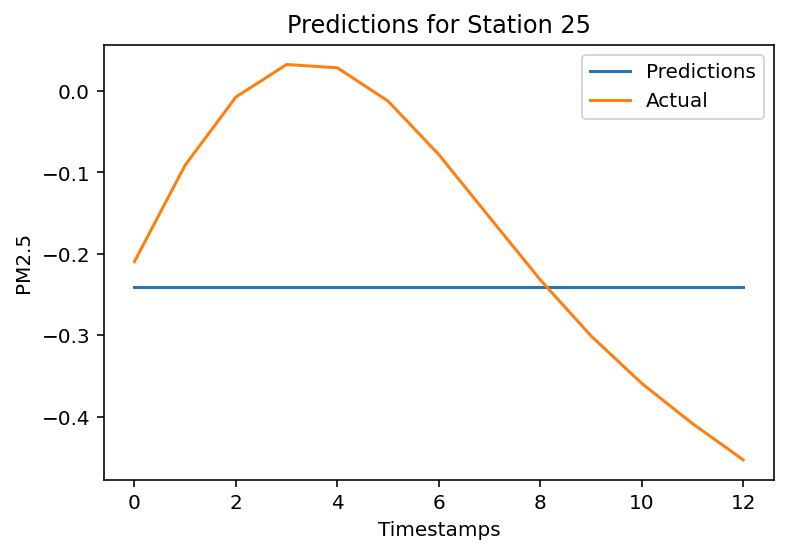

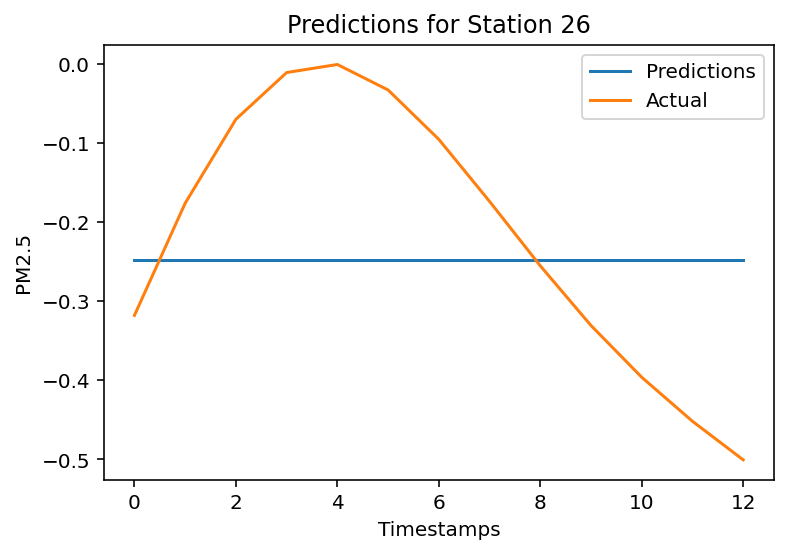

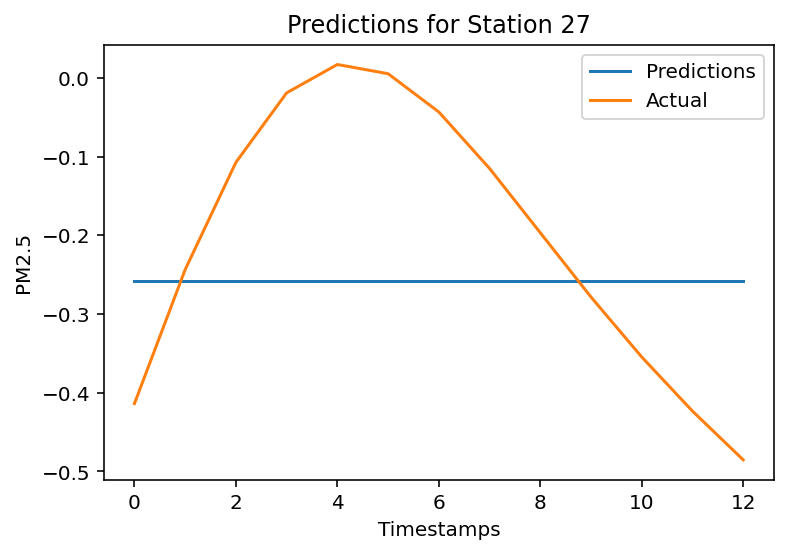

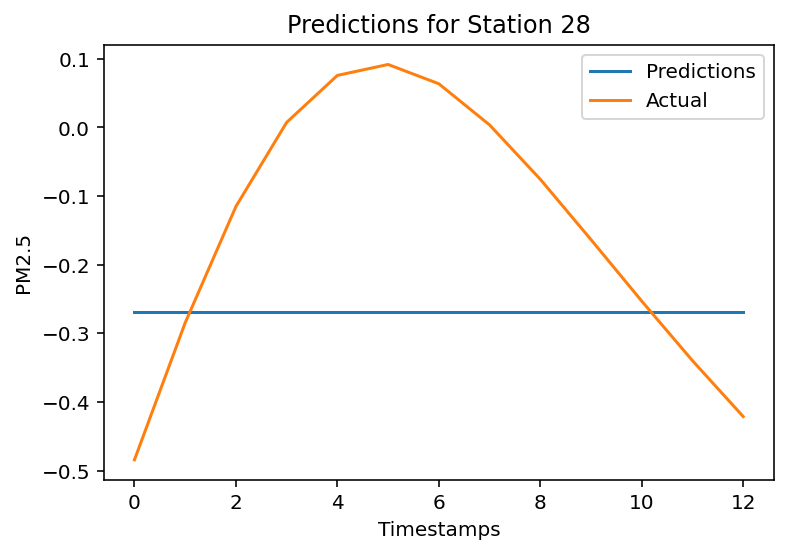

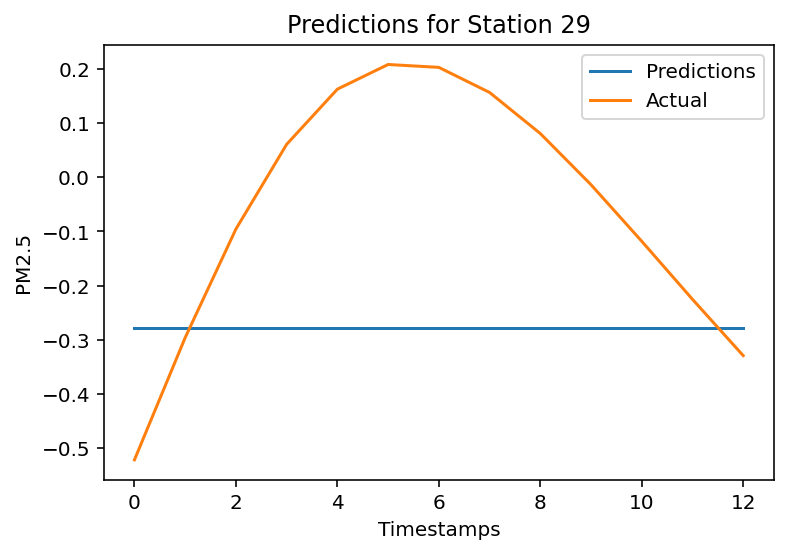

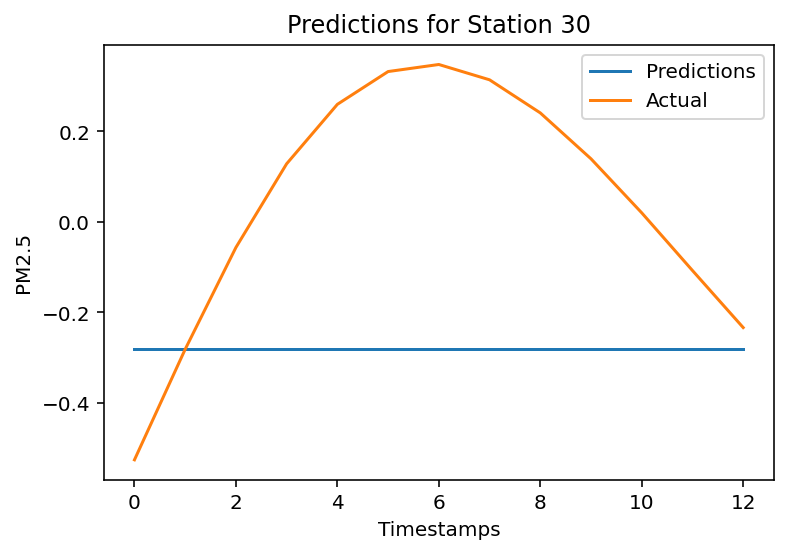

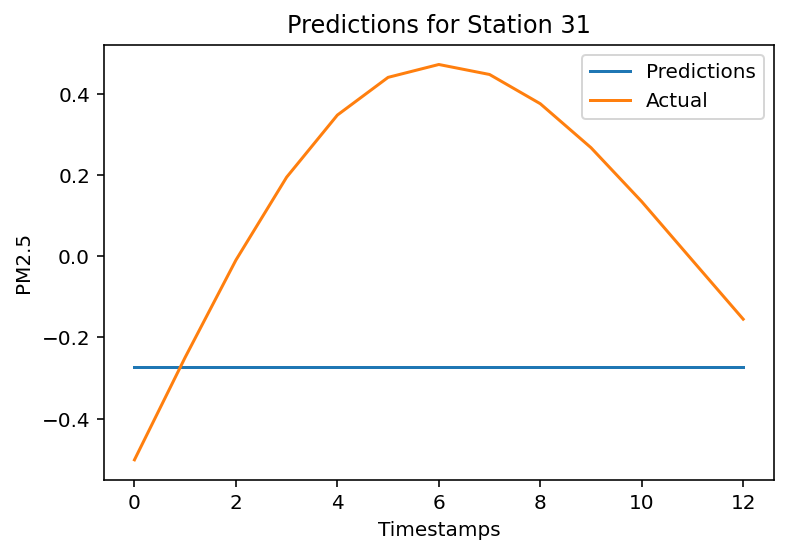

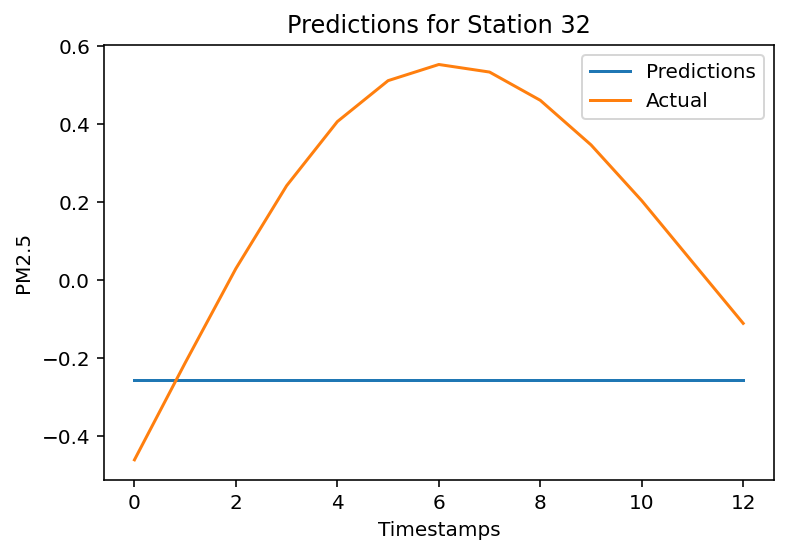

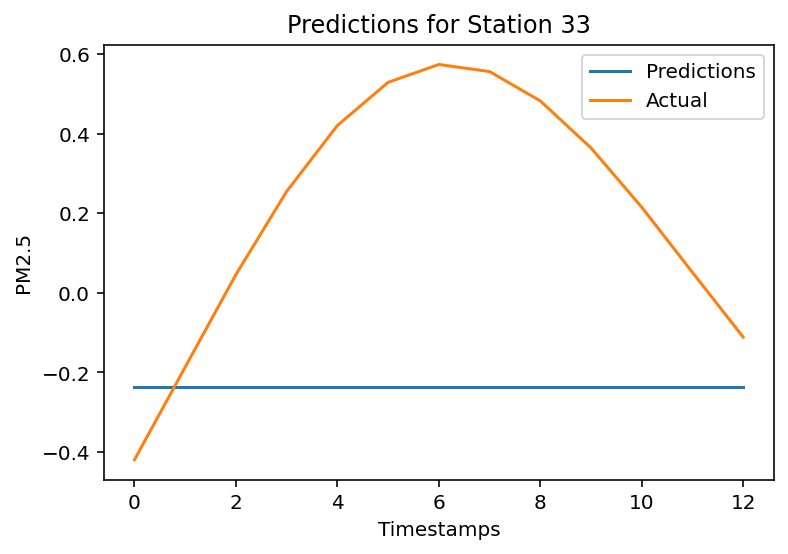

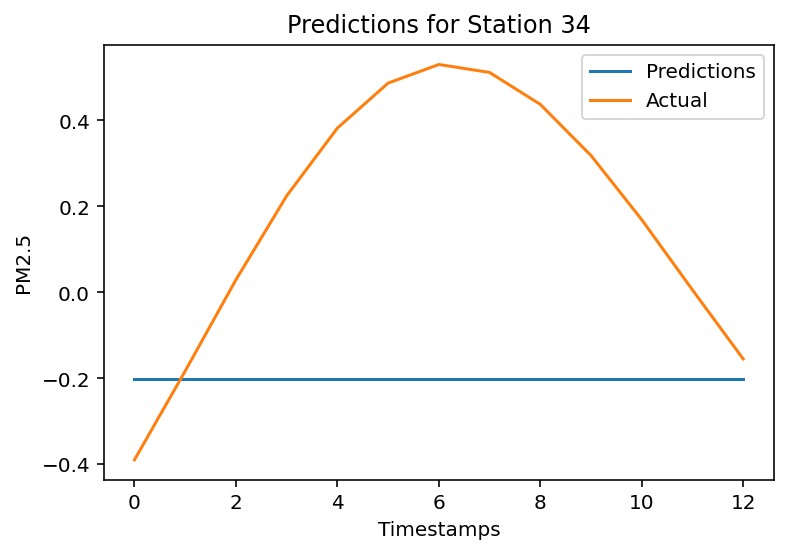

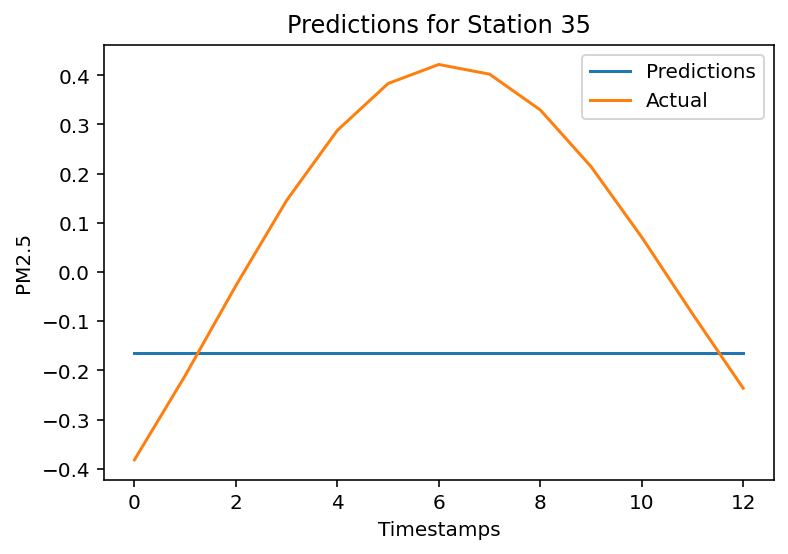

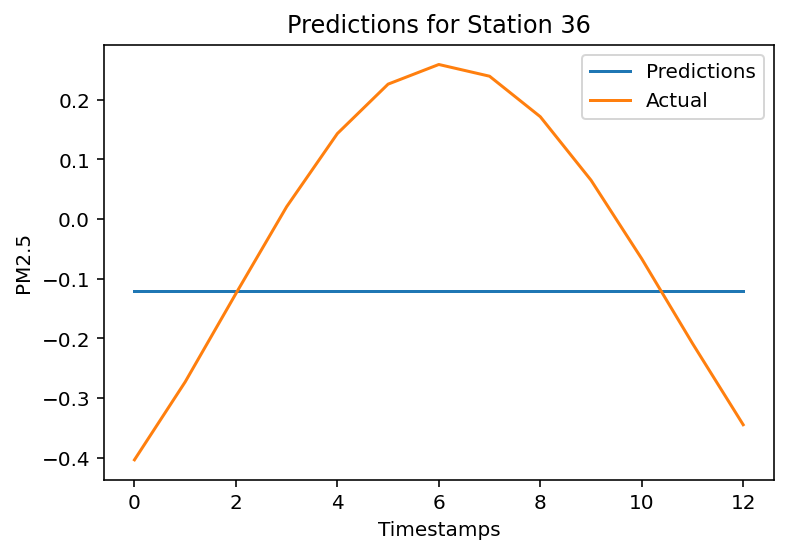

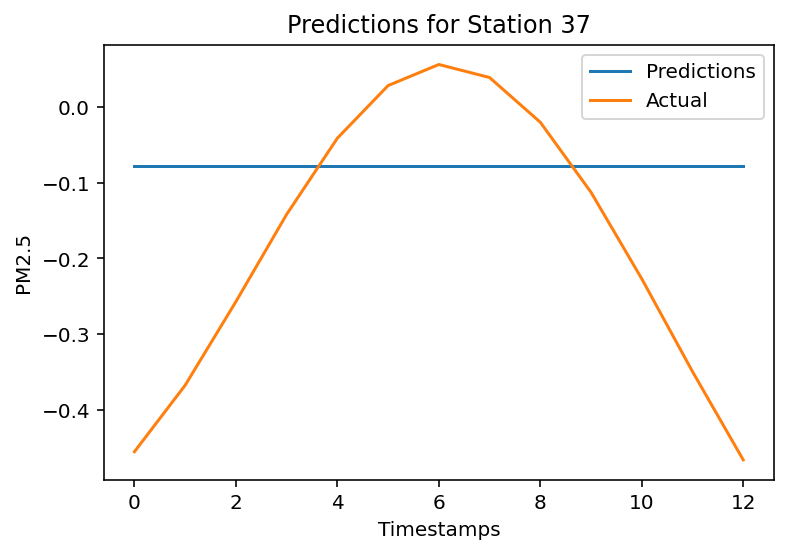

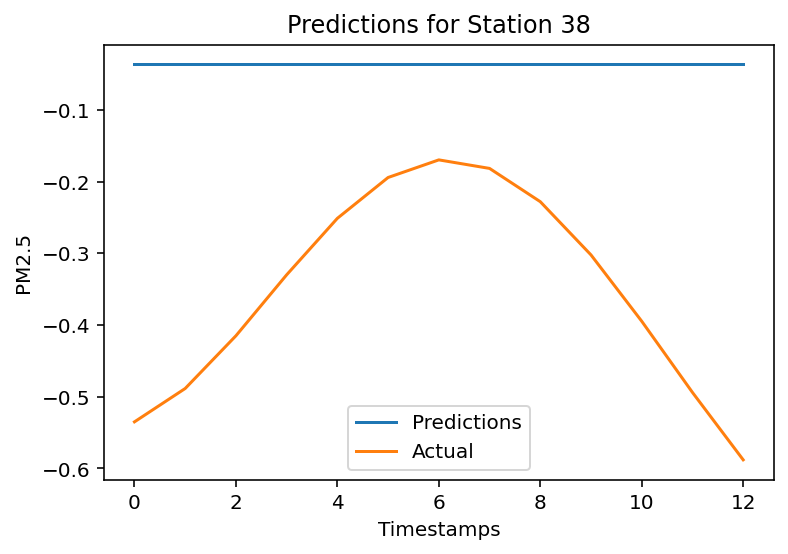

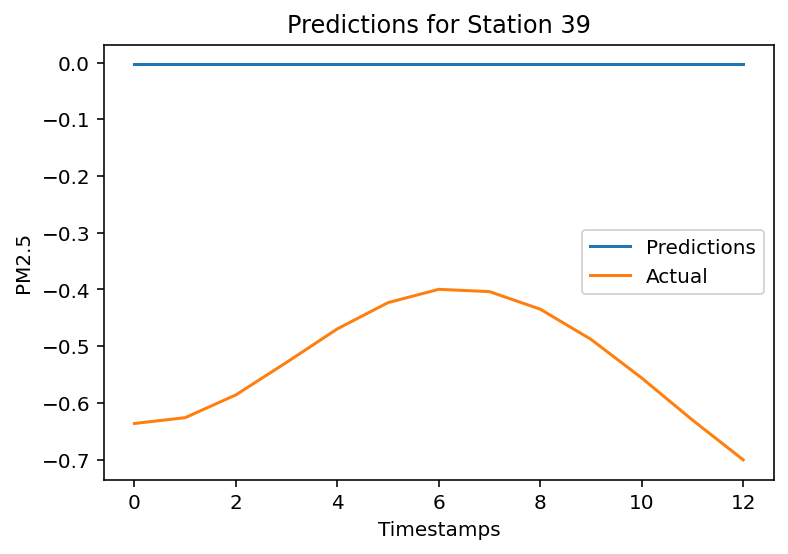

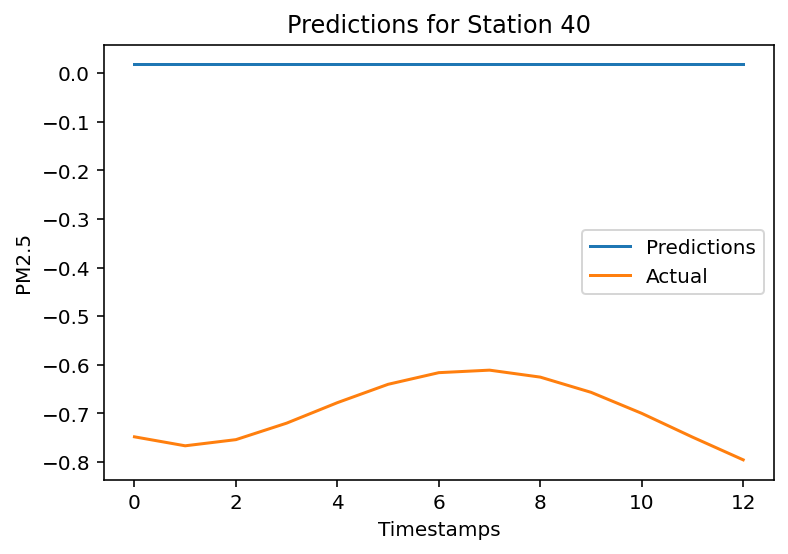

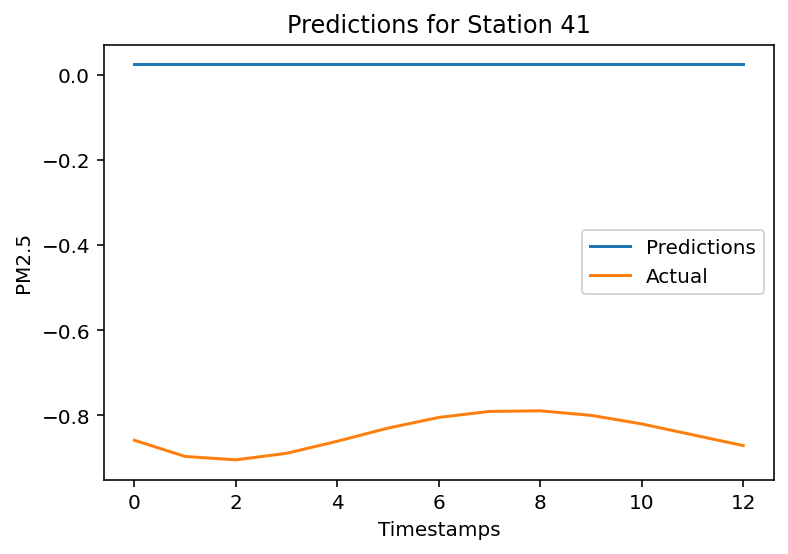

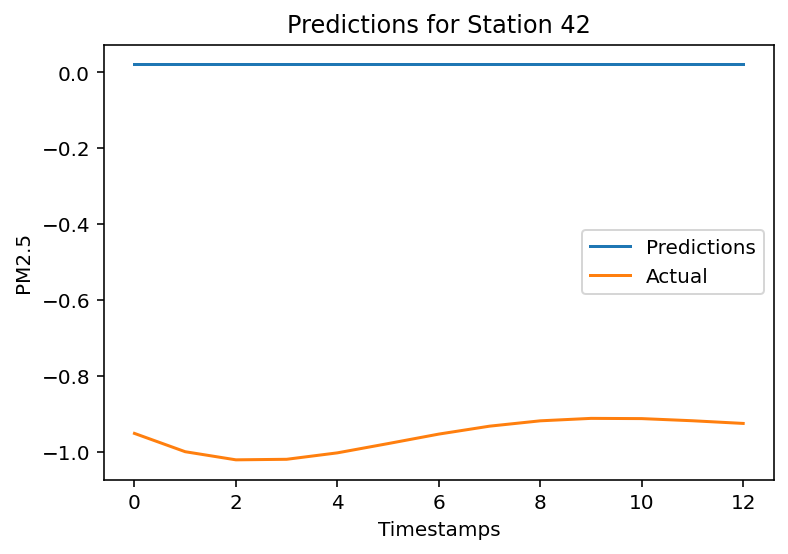

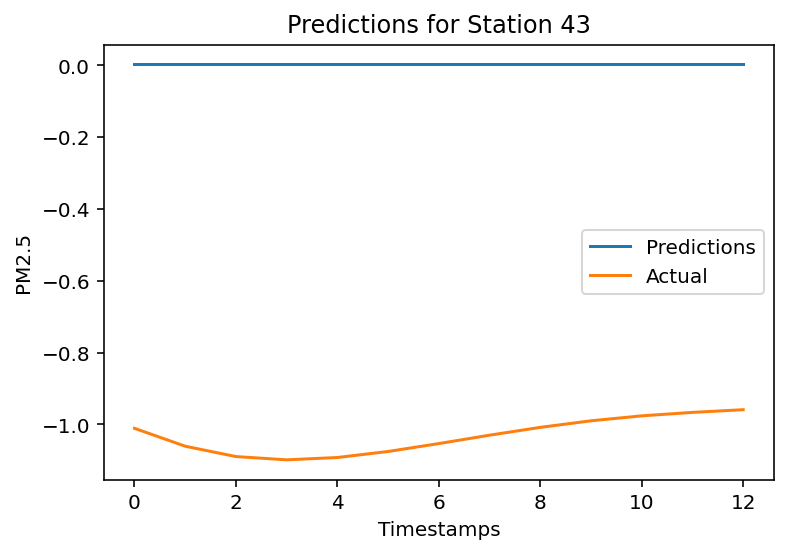

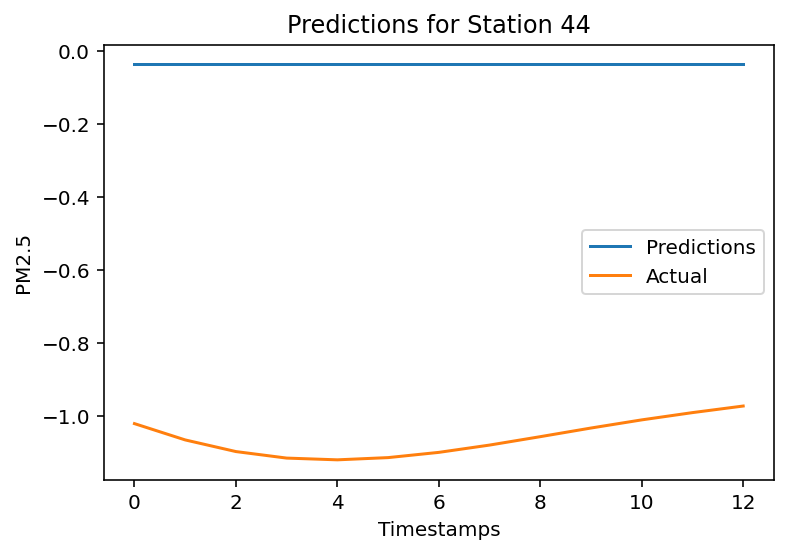

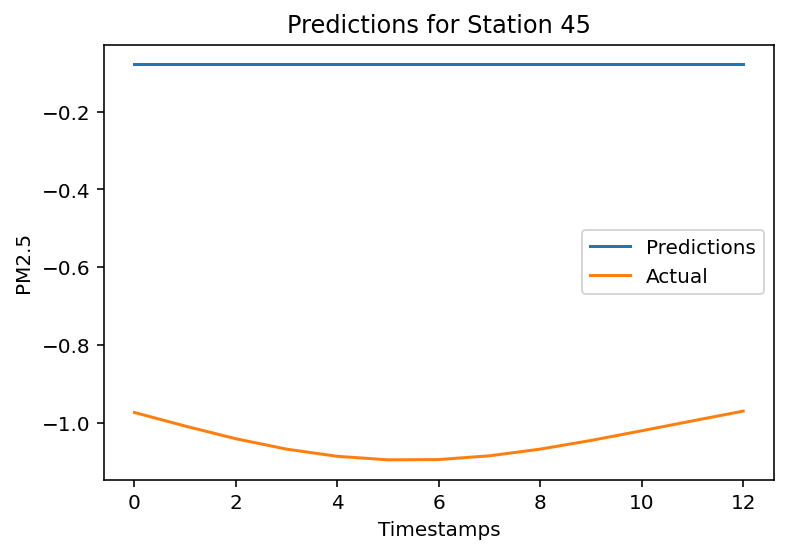

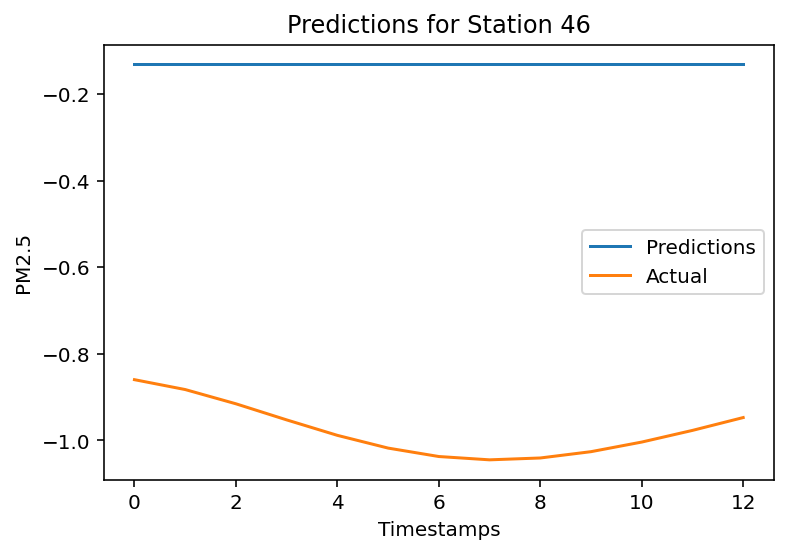

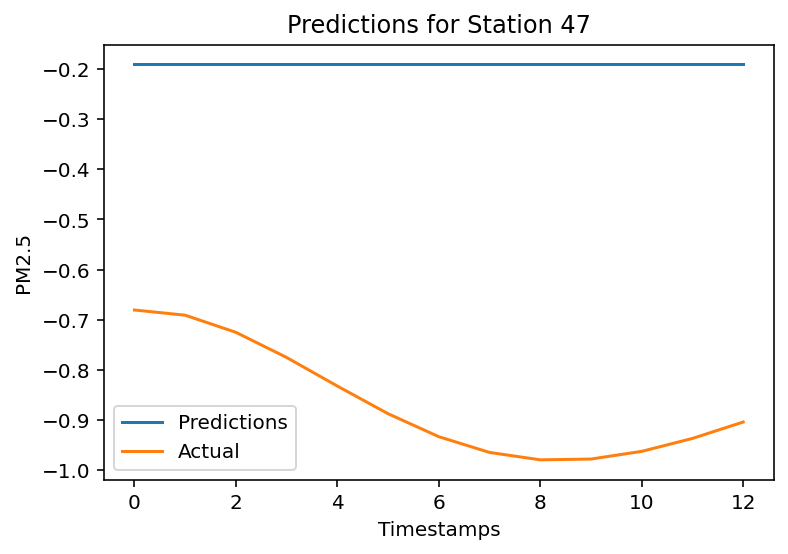

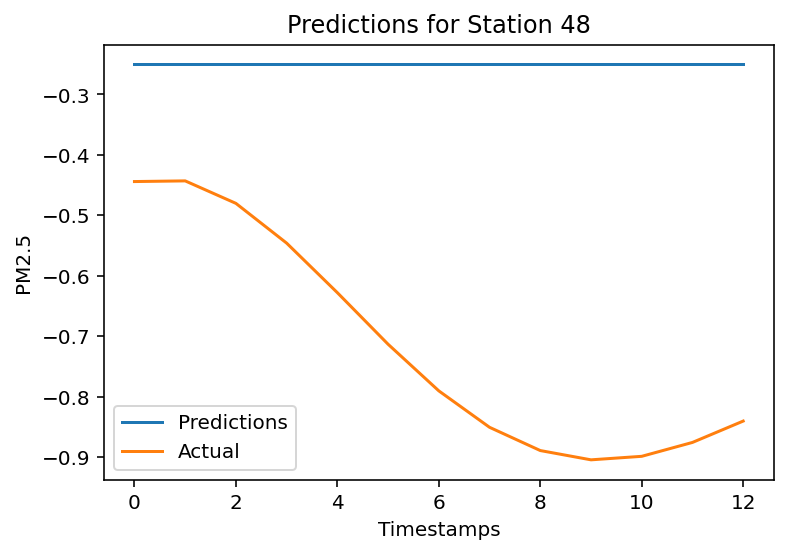

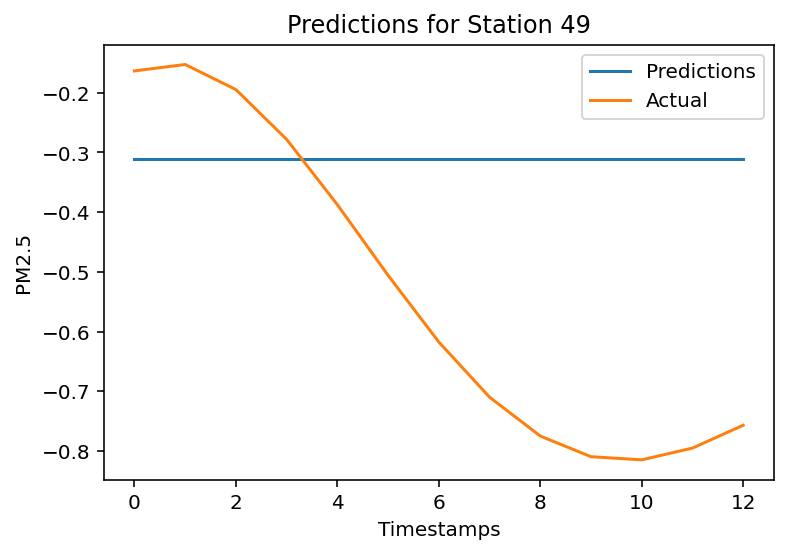

In [12]:
#Dictionaries for storing Predictions and Actual Values station-wise
station_preds = {}
station_actuals = {}

#Initialise empty lists for each station
for i in range(50):
    station_preds[i] = []
    station_actuals[i] = []

#Add predictions and actual values to dictionary
for i in range(0, len(preds), 50):
    for j in range(50):
        station_preds[j].append(preds[i+j])
        station_actuals[j].append(actual[i+j])

#Plot Predictions for Each Station
for i in range(50):
    plt.plot(station_preds[i], label = 'Predictions')
    plt.plot(station_actuals[i], label = 'Actual')
    plt.xlabel('Timestamps')
    plt.ylabel('PM2.5')
    plt.legend()
    title = 'Predictions for Station ' + str(i)
    plt.title(title)
    plt.show()

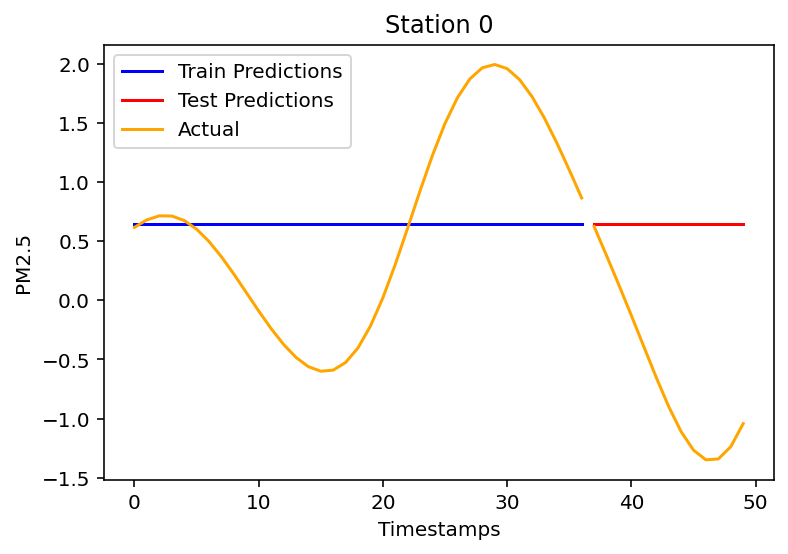

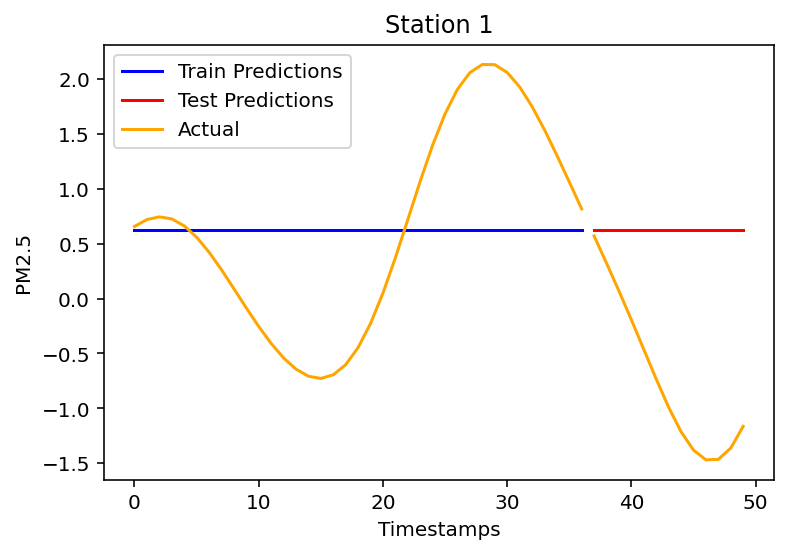

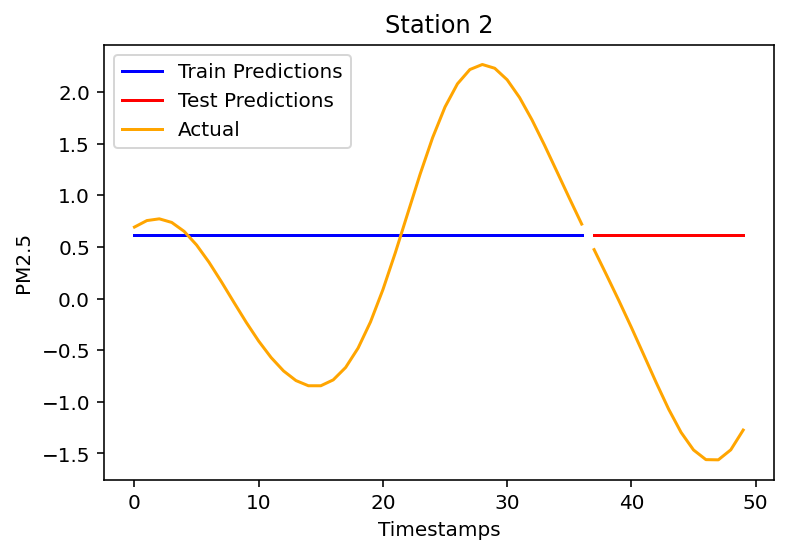

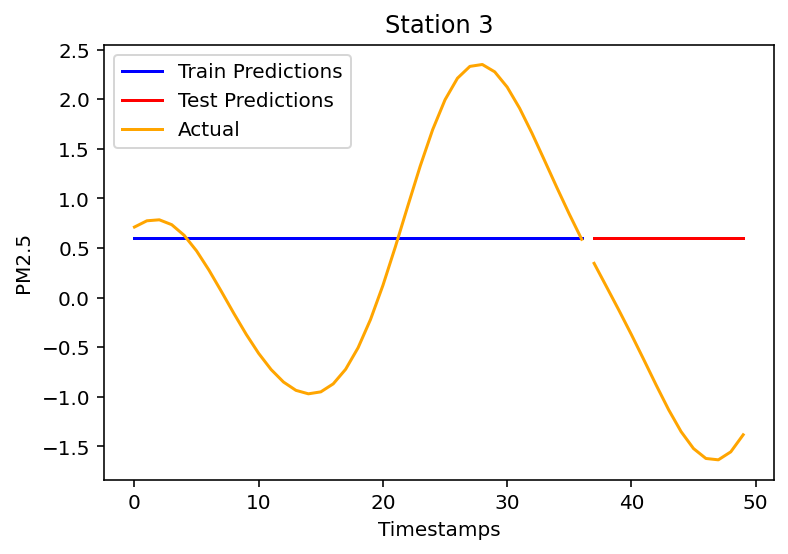

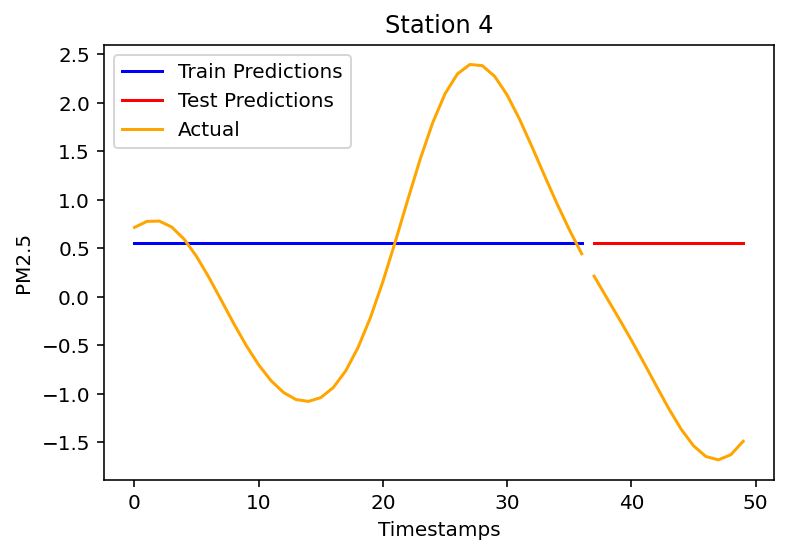

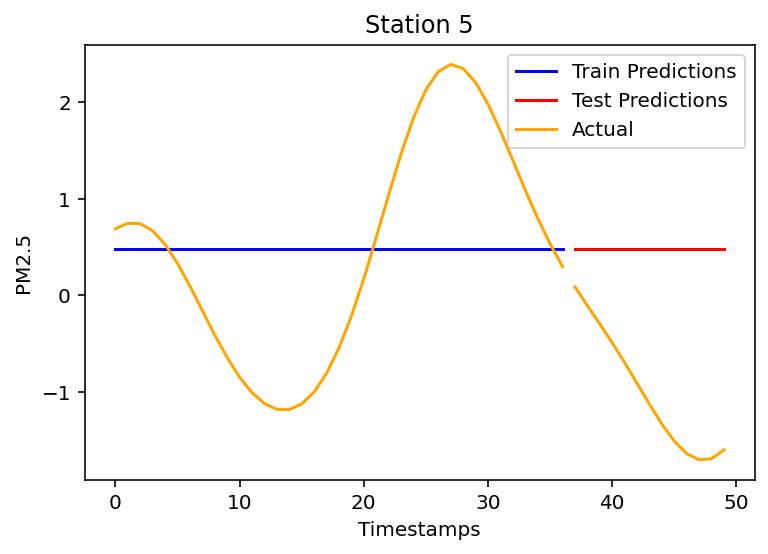

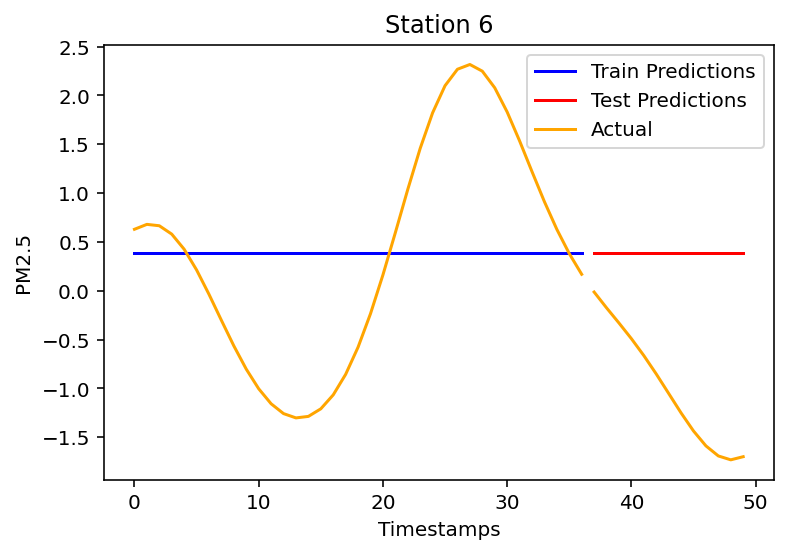

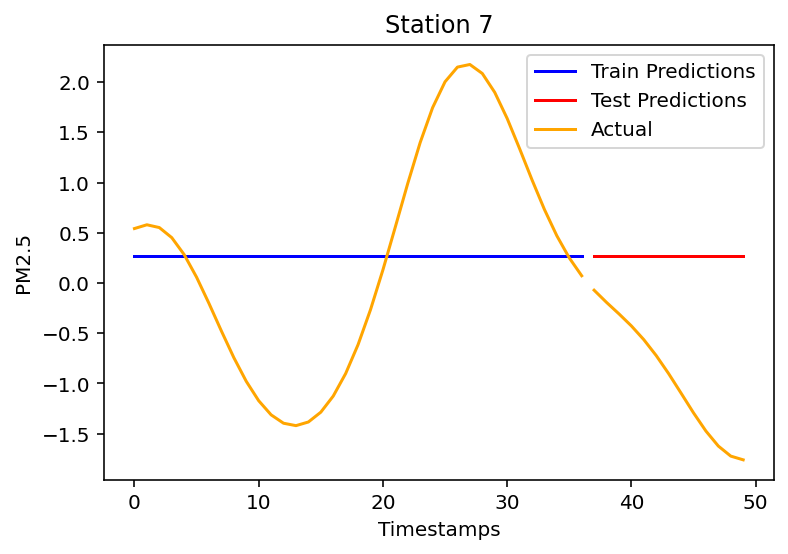

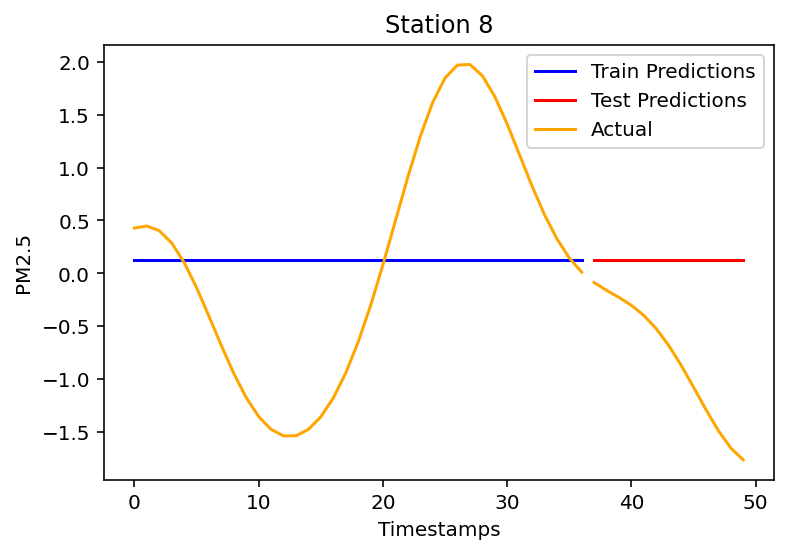

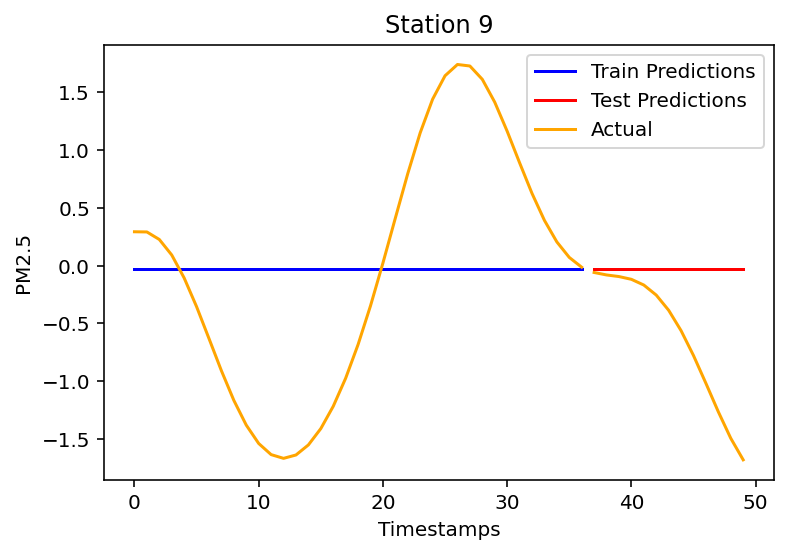

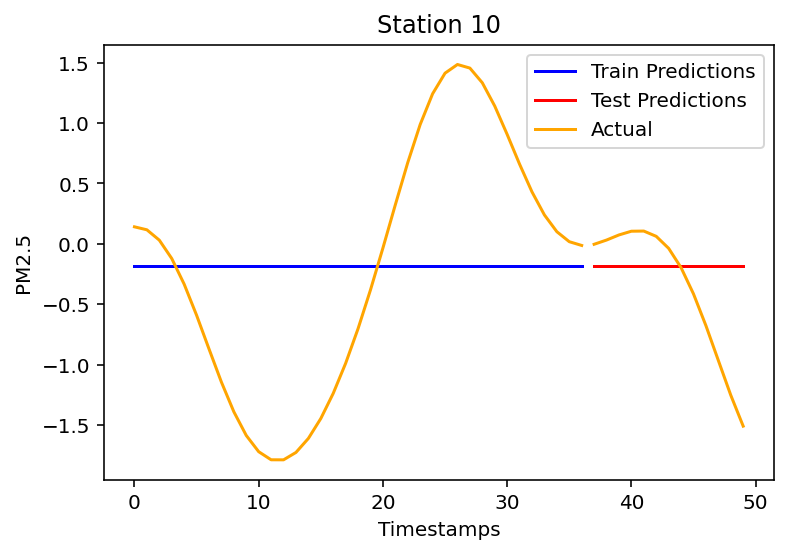

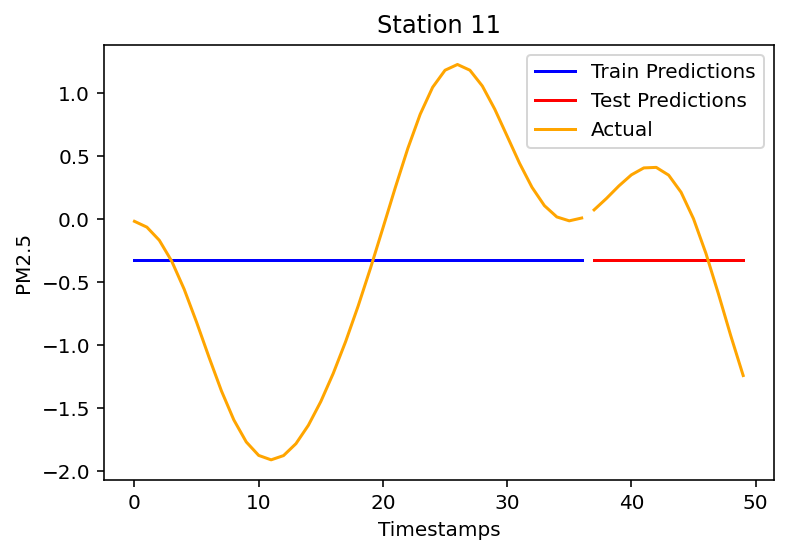

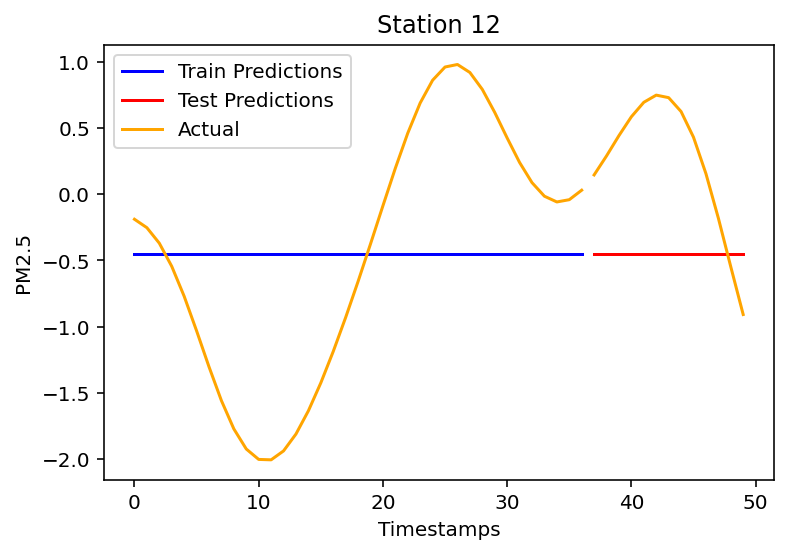

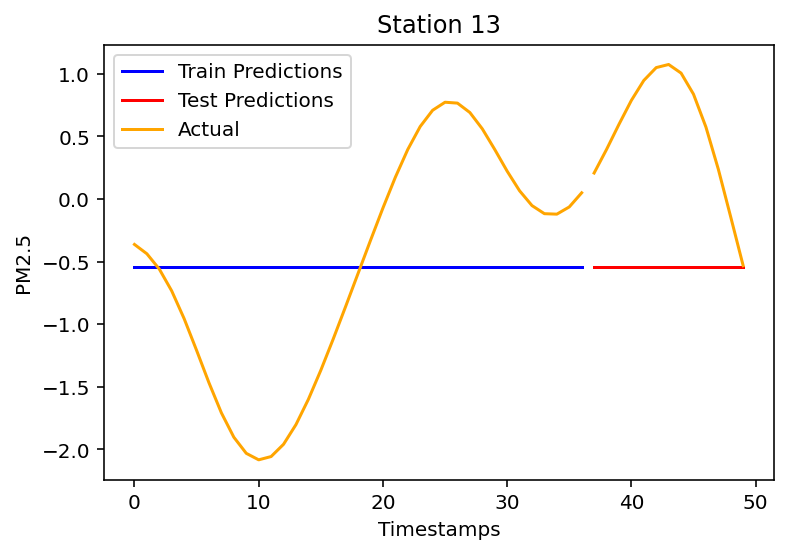

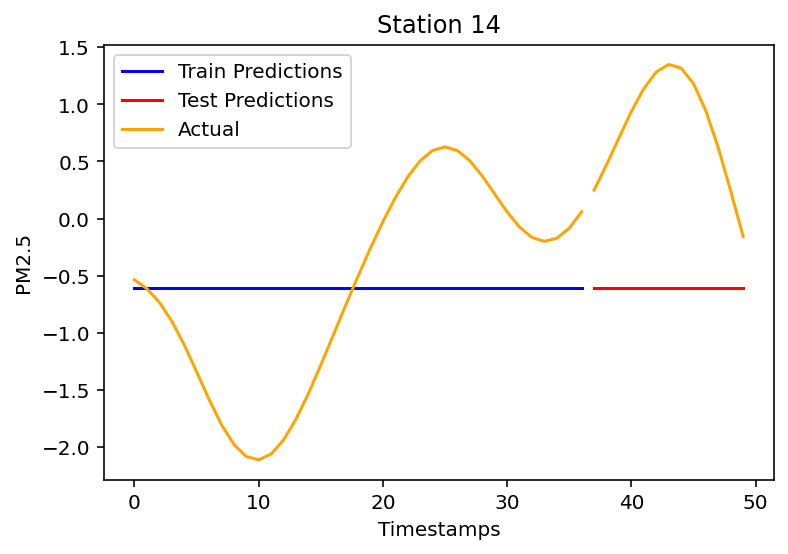

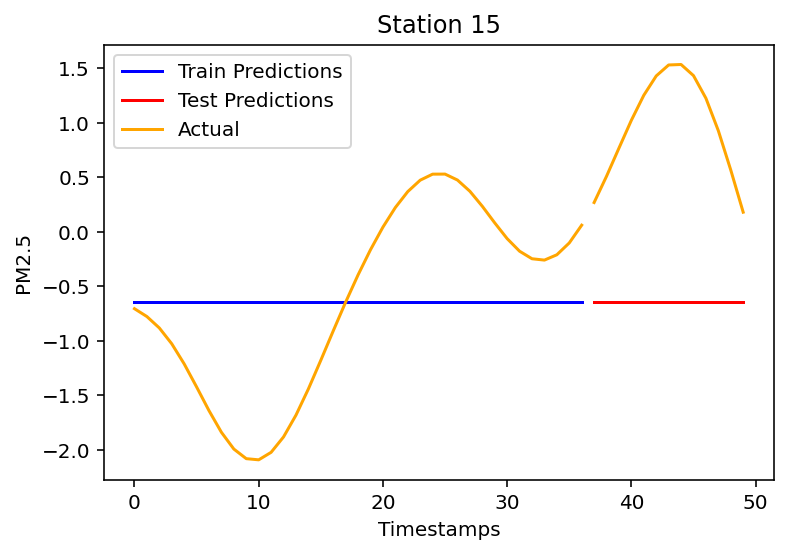

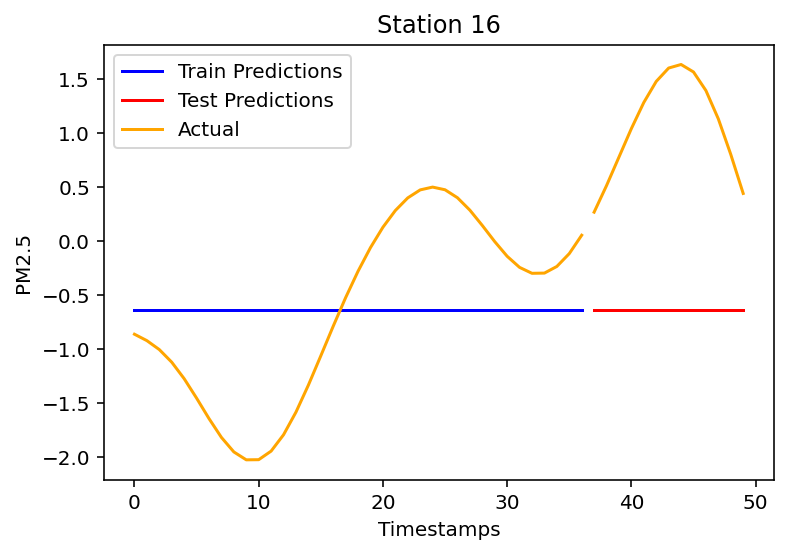

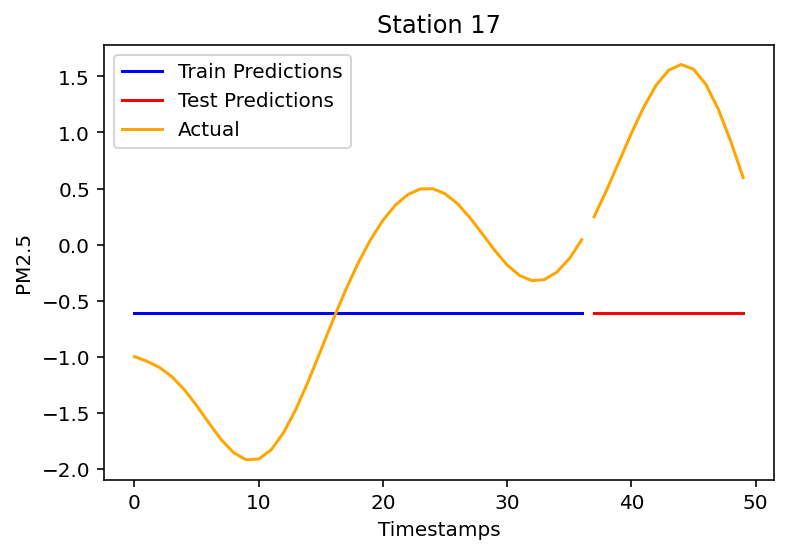

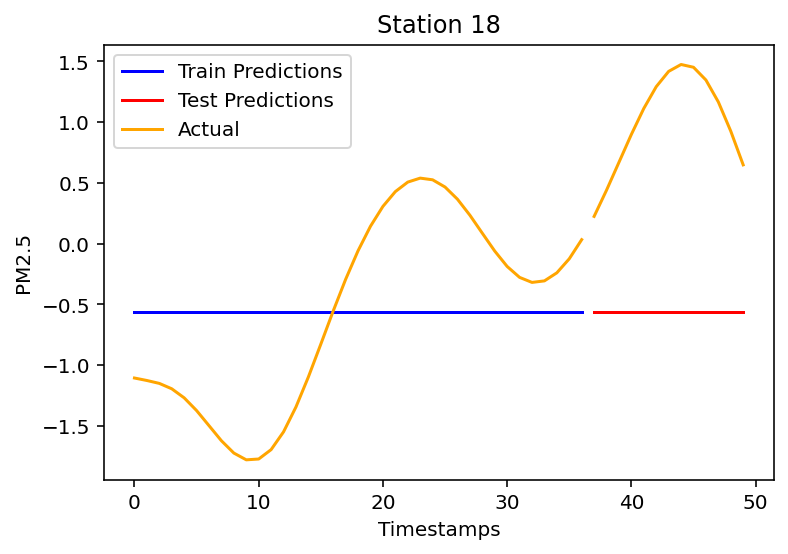

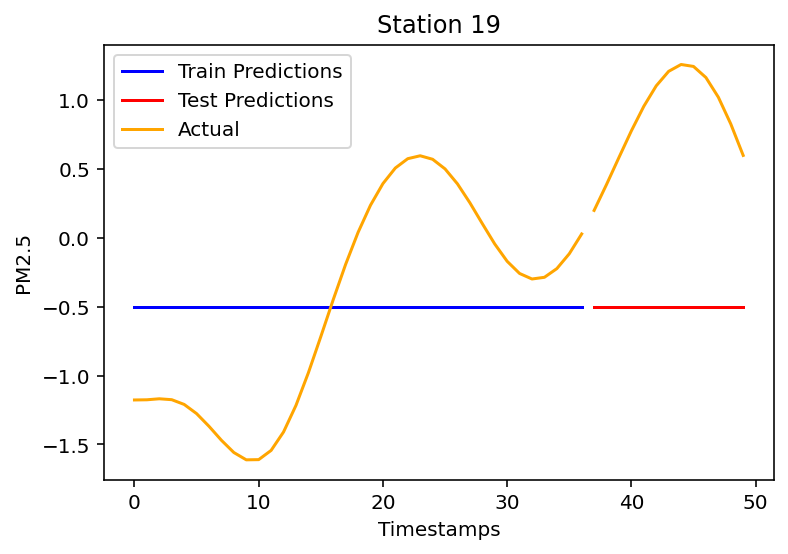

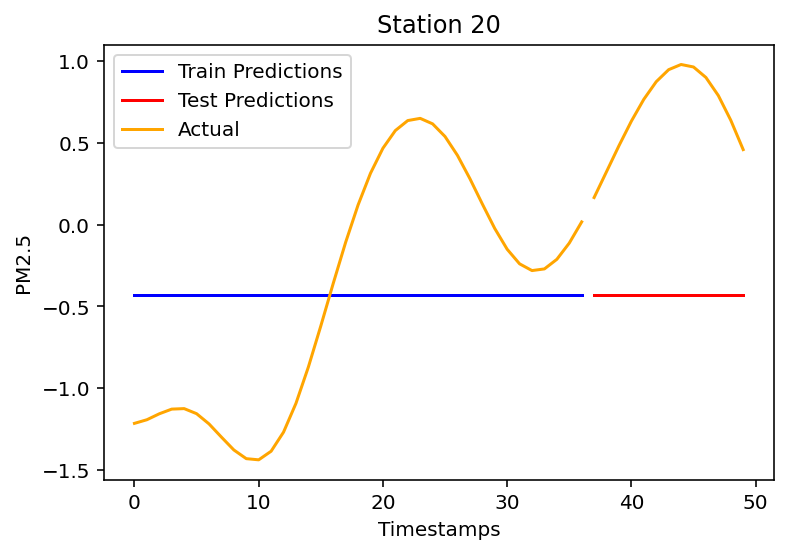

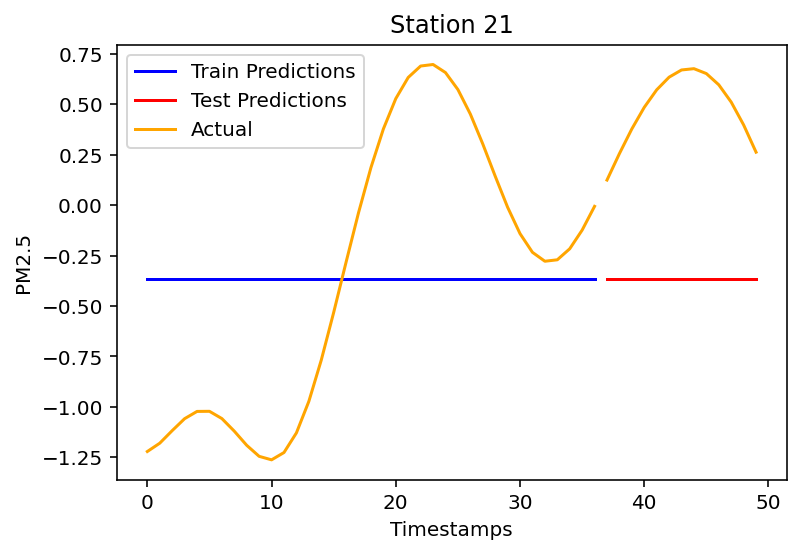

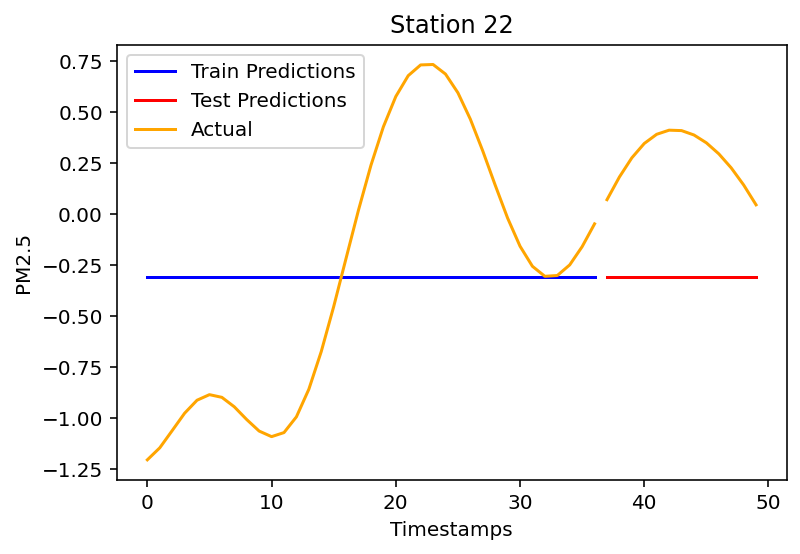

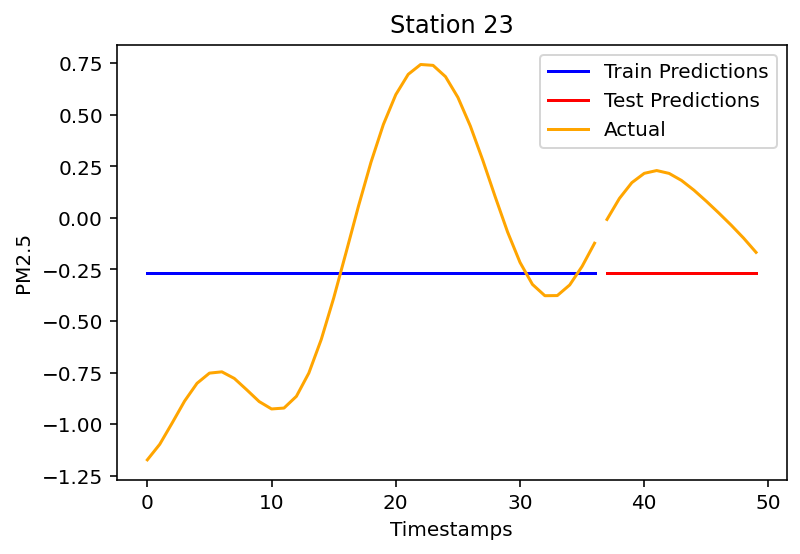

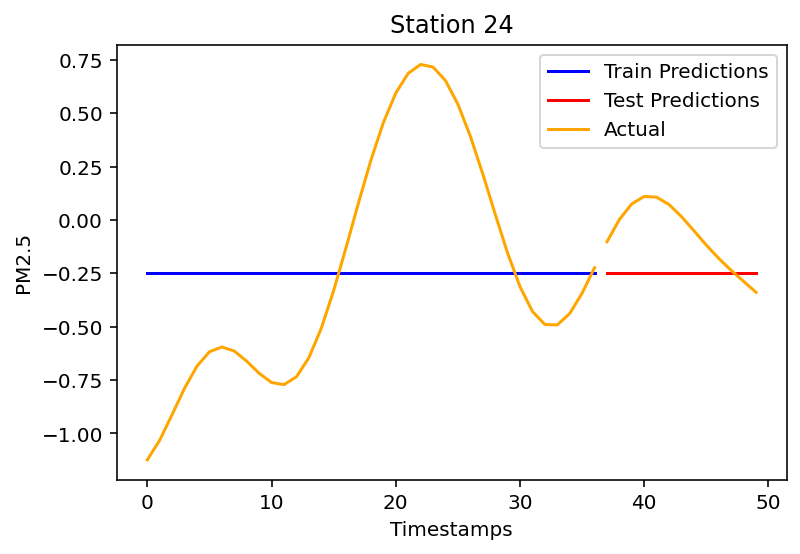

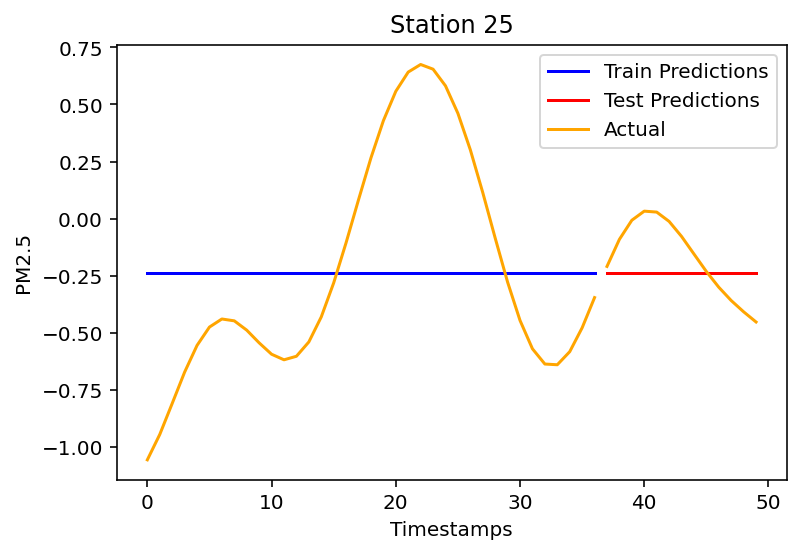

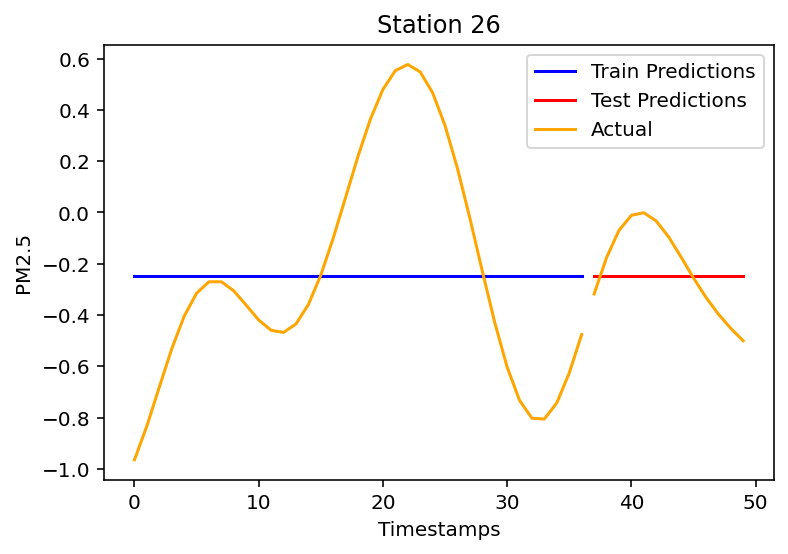

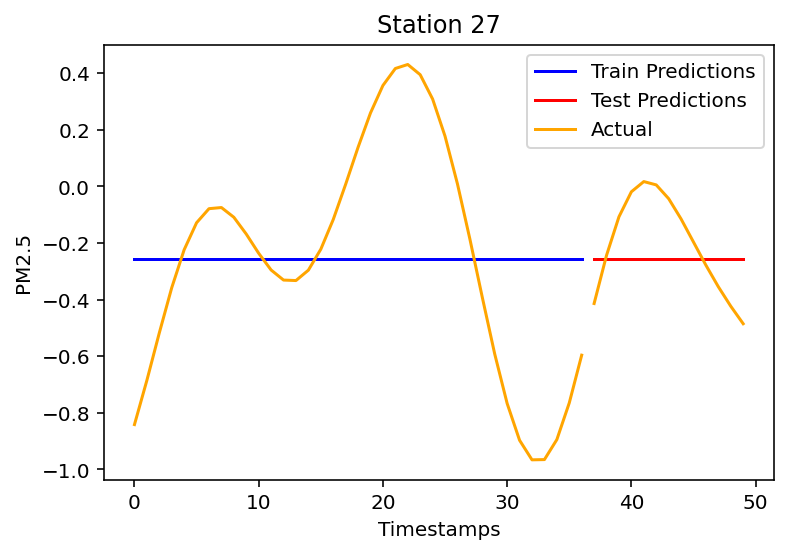

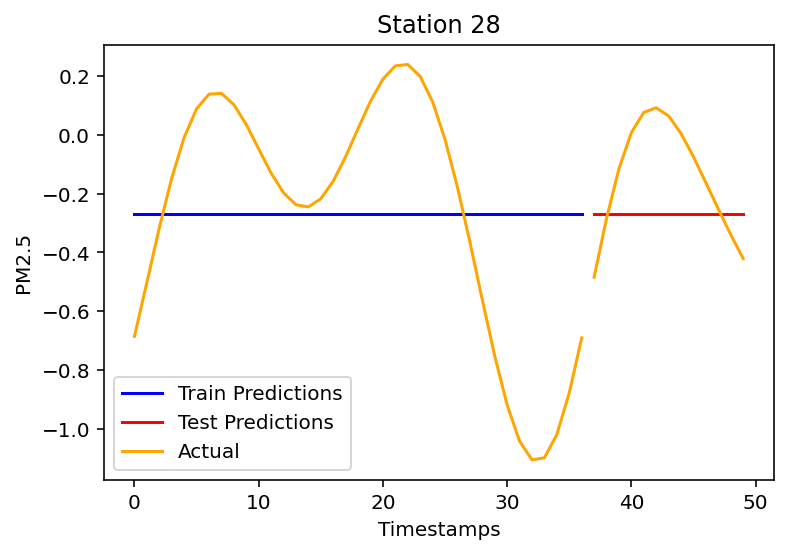

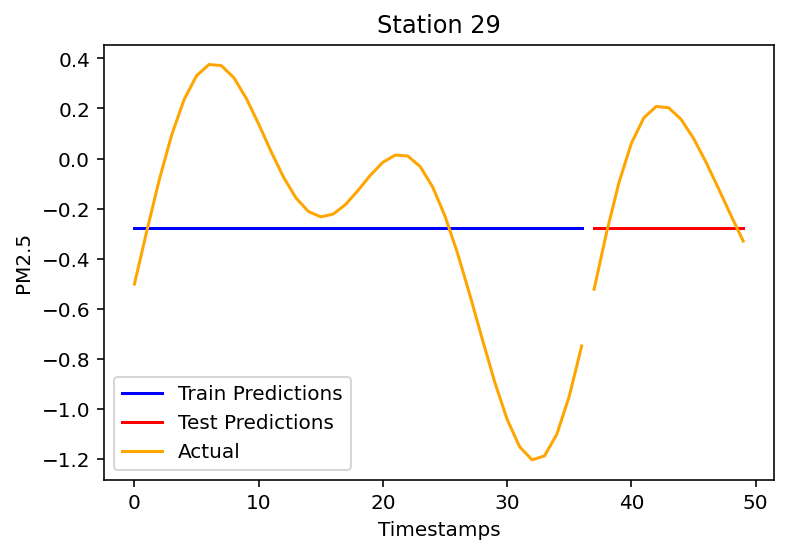

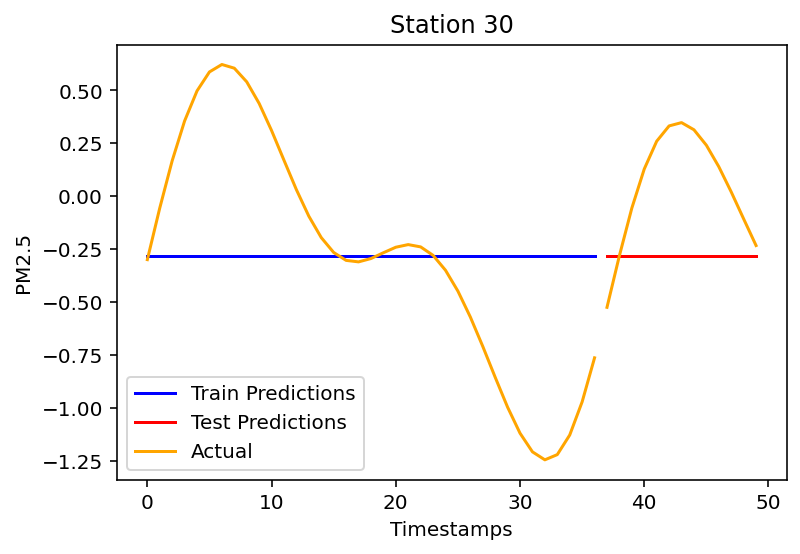

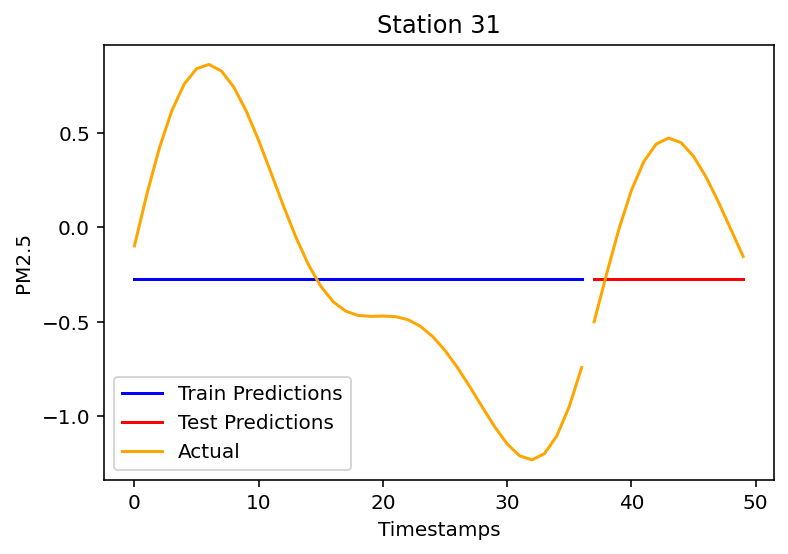

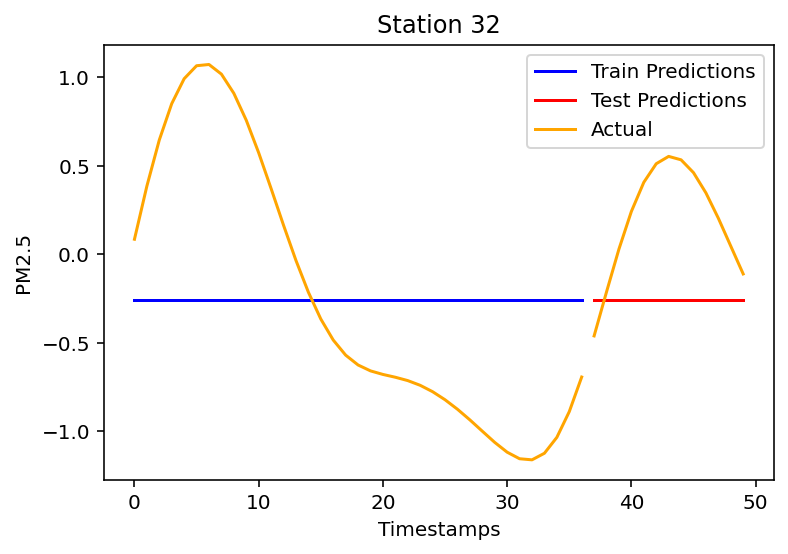

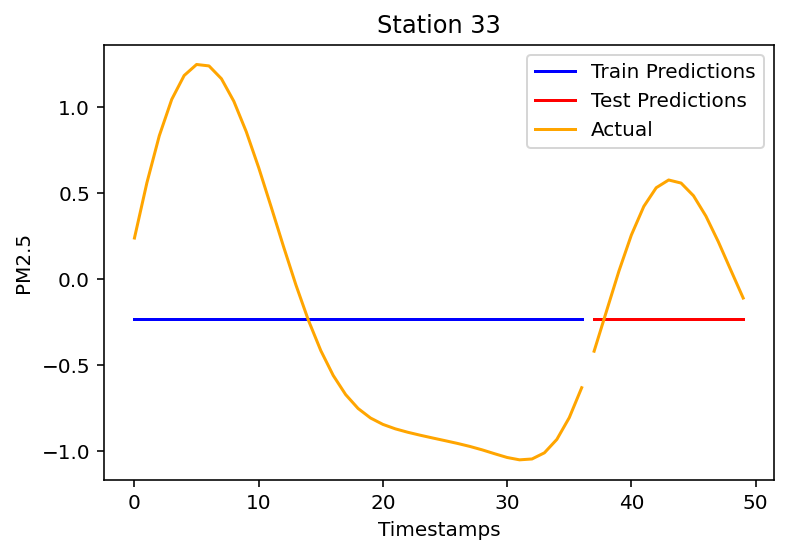

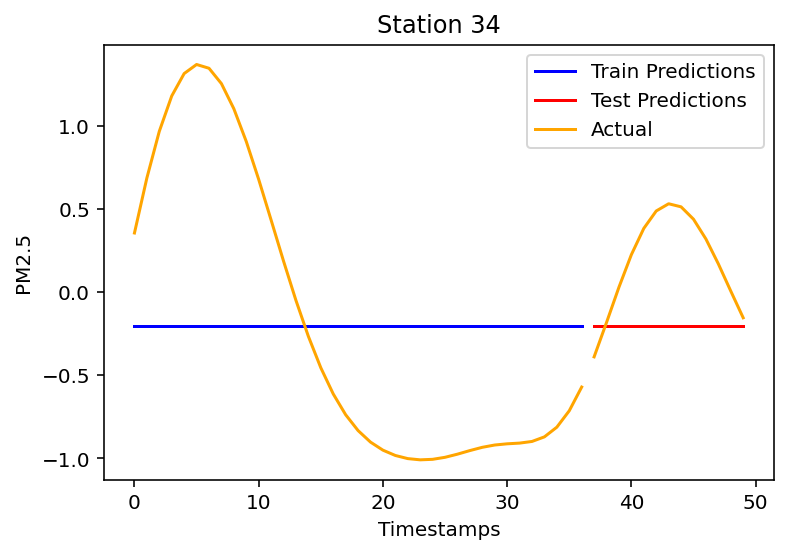

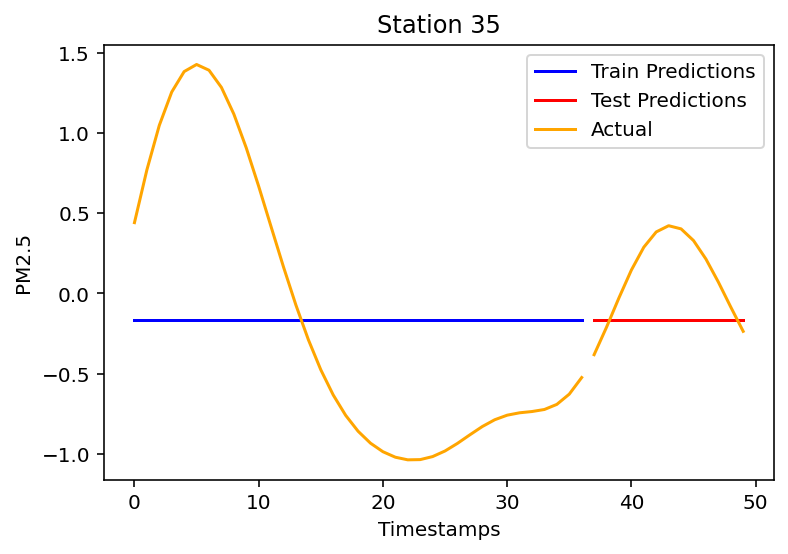

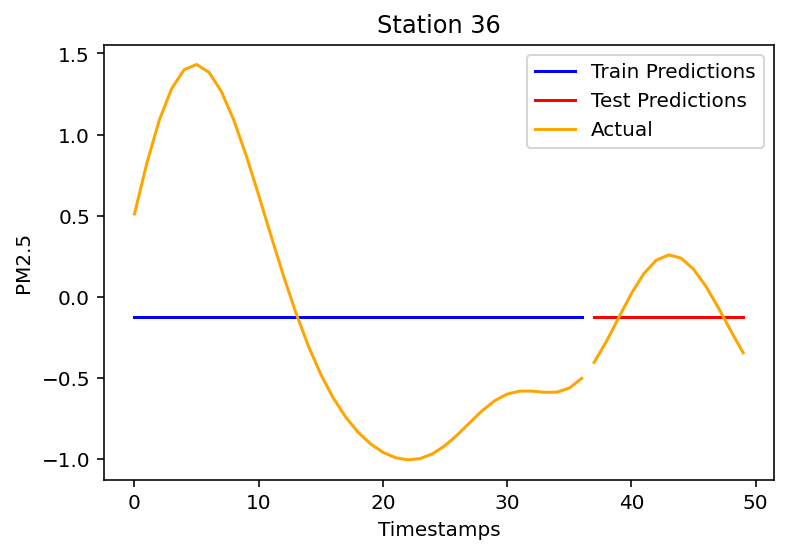

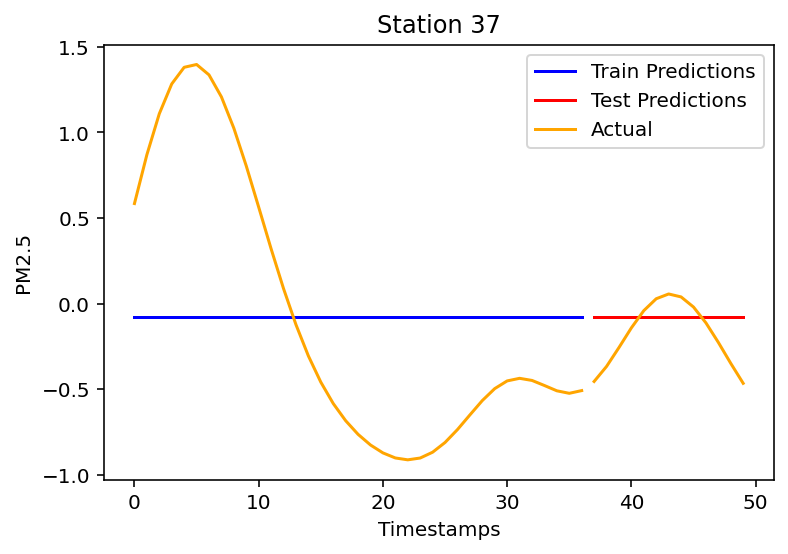

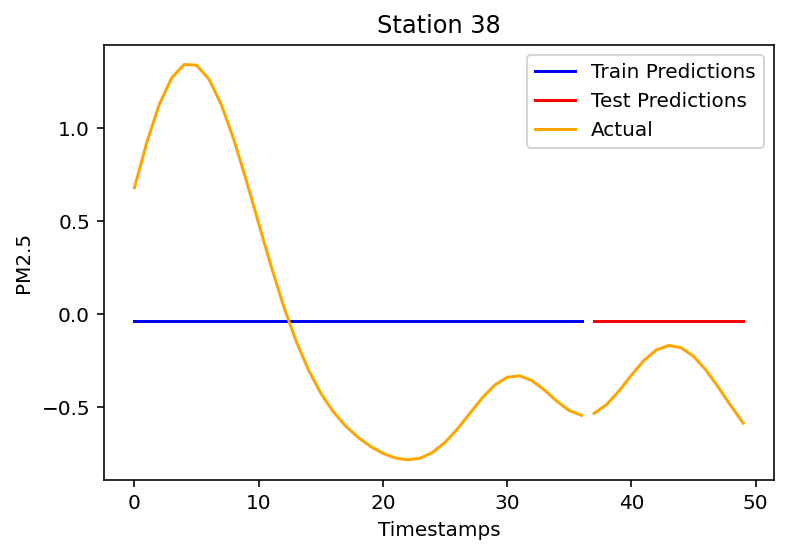

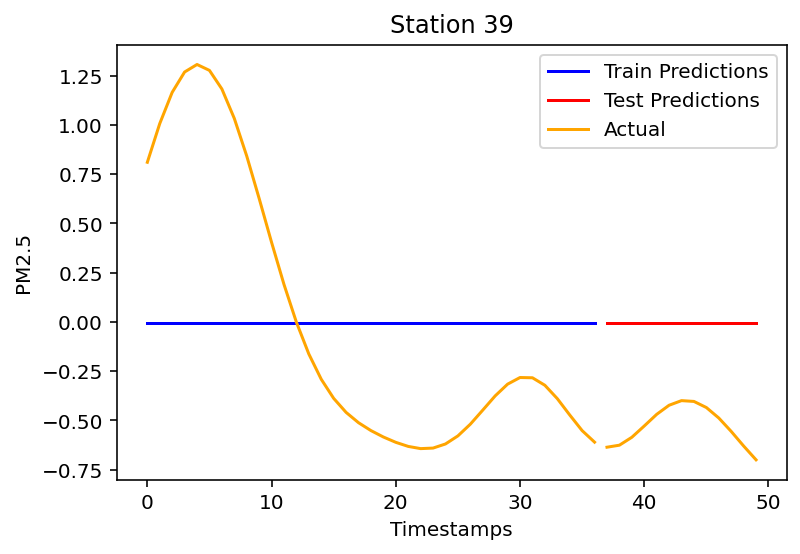

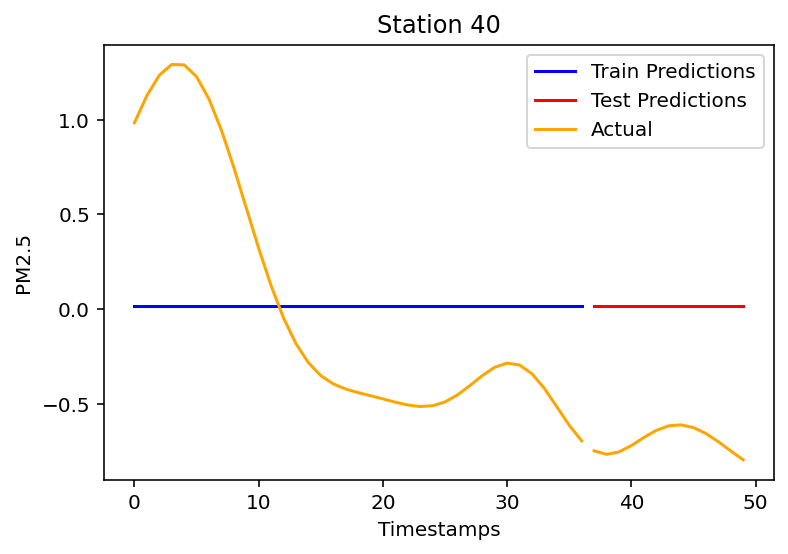

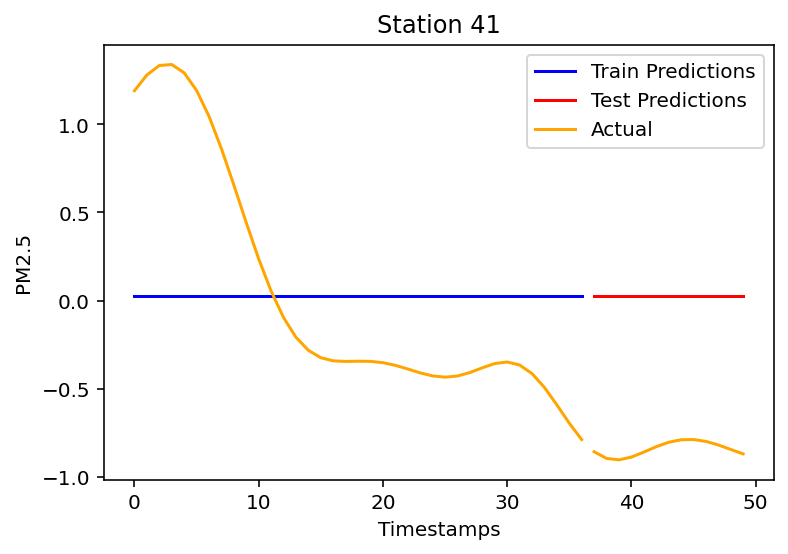

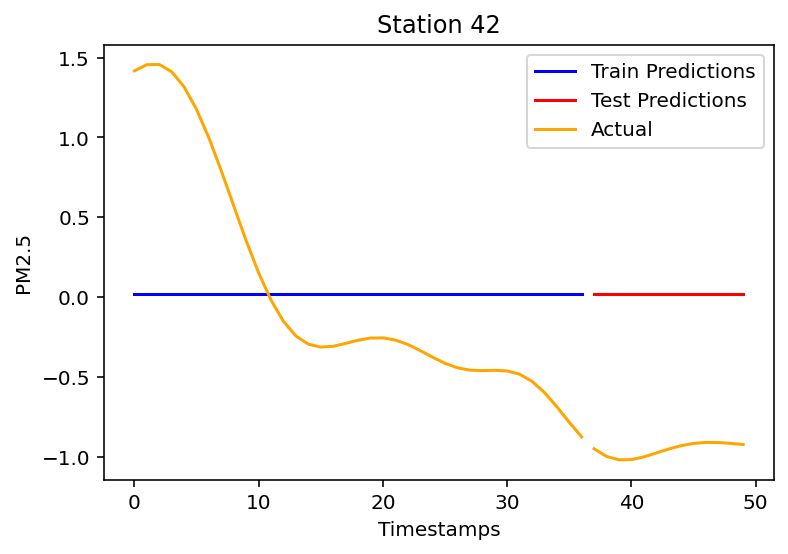

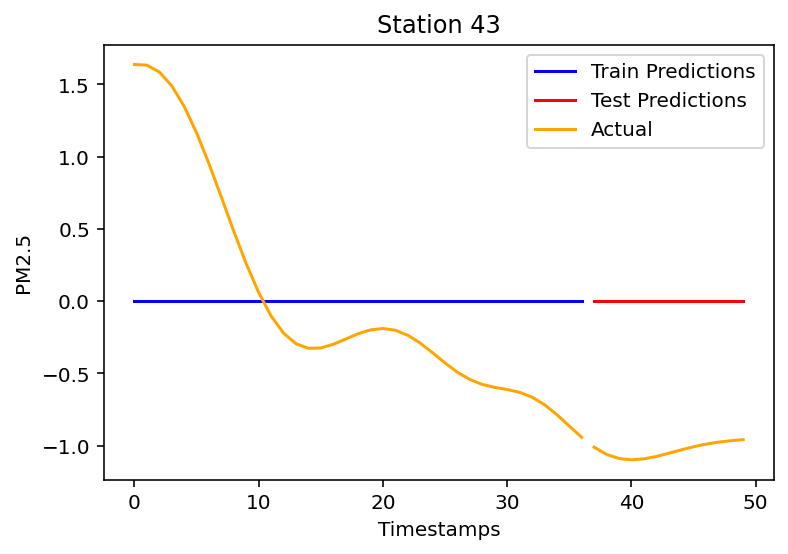

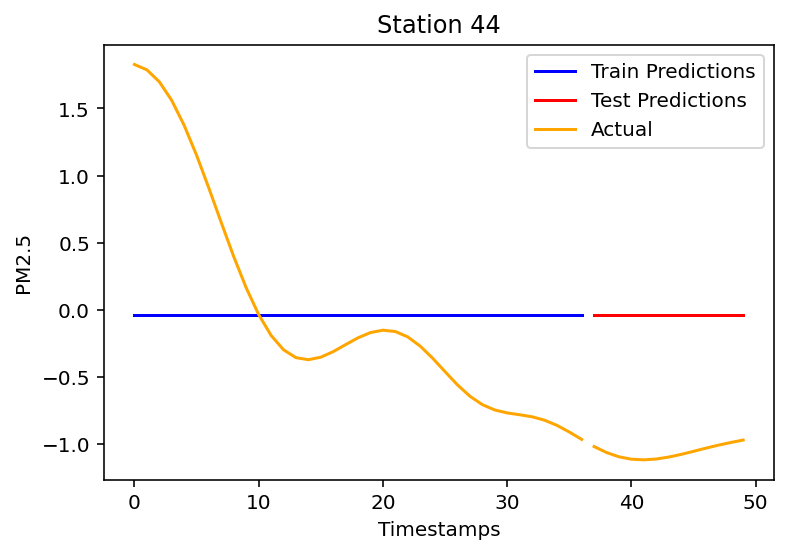

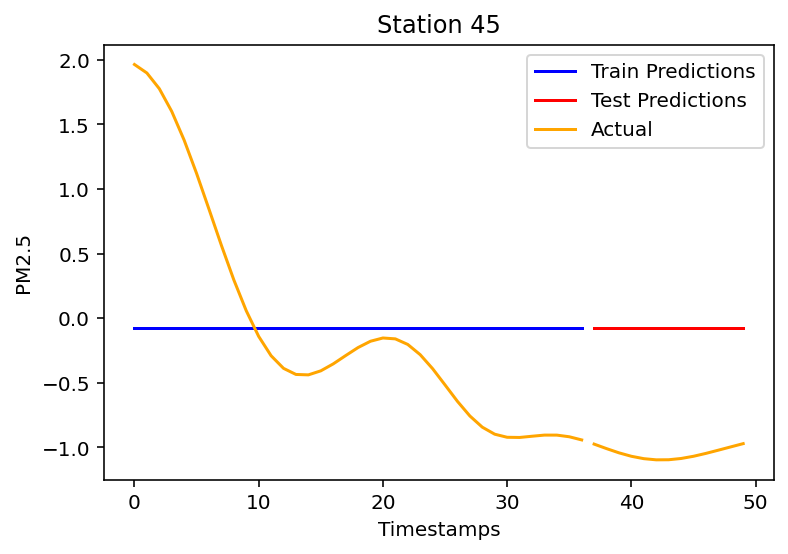

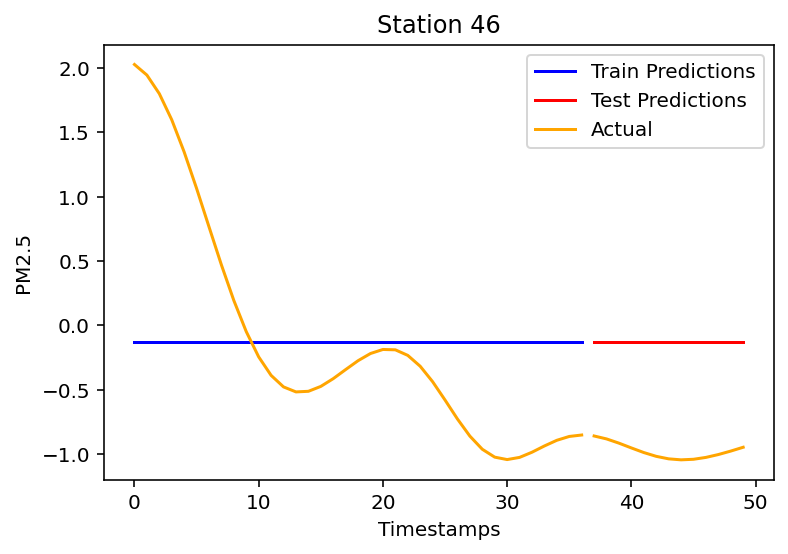

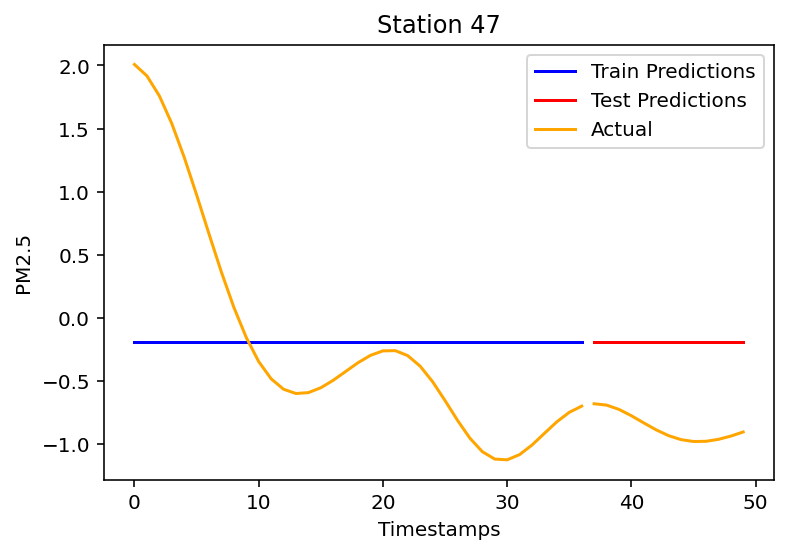

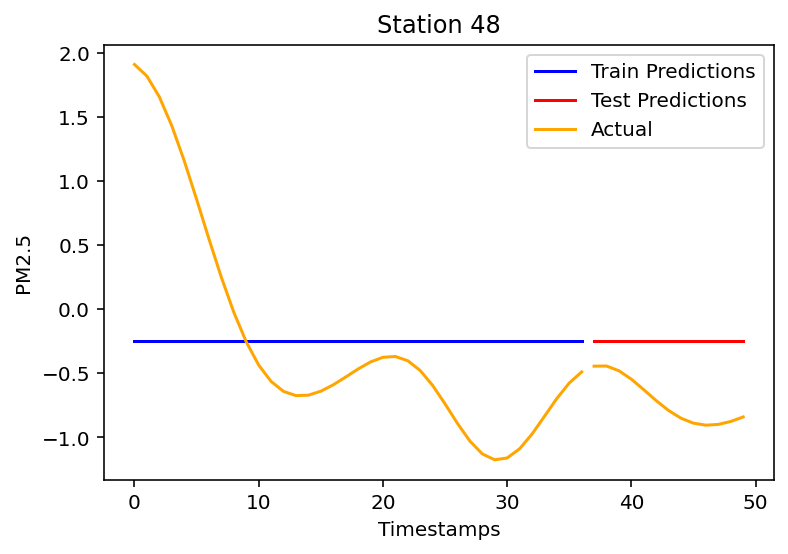

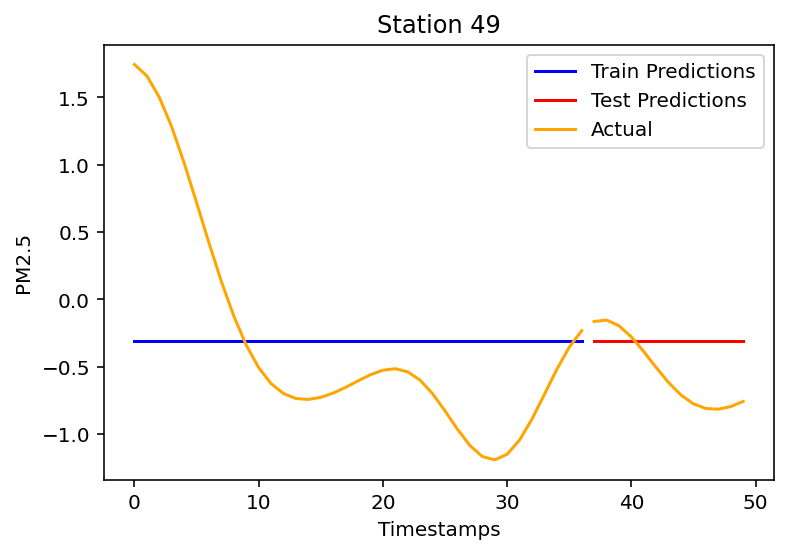

In [13]:
train_preds = out[data.train_mask].squeeze().detach()
train_actual = data.y[data.train_mask].squeeze()

train_stationwise_preds = {}
actual_stationwise_values = {}

for i in range(50):
    train_stationwise_preds[i] = []
    actual_stationwise_values[i] = []

for i in range(0, len(train_preds), 50):
    for j in range(50):
        train_stationwise_preds[j].append(train_preds[i+j])
        actual_stationwise_values[j].append(train_actual[i+j])

# Number of Timestamps in Training Data
n_ts = n_train//50

for i in range(50):
    plt.plot(range(n_ts), train_stationwise_preds[i], label = 'Train Predictions', color = 'blue')
    plt.plot(range(n_ts, n_ts+len(station_actuals[0])), station_preds[i], label = 'Test Predictions', color = 'red')
    plt.plot(range(n_ts), actual_stationwise_values[i], label = 'Actual', color = 'orange')
    plt.plot(range(n_ts, n_ts+len(station_actuals[0])), station_actuals[i], color = 'orange')
    plt.xlabel('Timestamps')
    plt.ylabel('PM2.5')
    plt.legend()
    title = 'Station ' + str(i)
    plt.title(title)
    plt.show()

# For Correlated Sine Waves

array([[0.5    , 0.45   , 0.405  , 0.3645 , 0.32805],
       [0.45   , 0.5    , 0.45   , 0.405  , 0.3645 ],
       [0.405  , 0.45   , 0.5    , 0.45   , 0.405  ],
       [0.3645 , 0.405  , 0.45   , 0.5    , 0.45   ],
       [0.32805, 0.3645 , 0.405  , 0.45   , 0.5    ]])

y=array([-0.24450766,  0.71878464,  0.45031305,  0.35116837,  0.03835798])


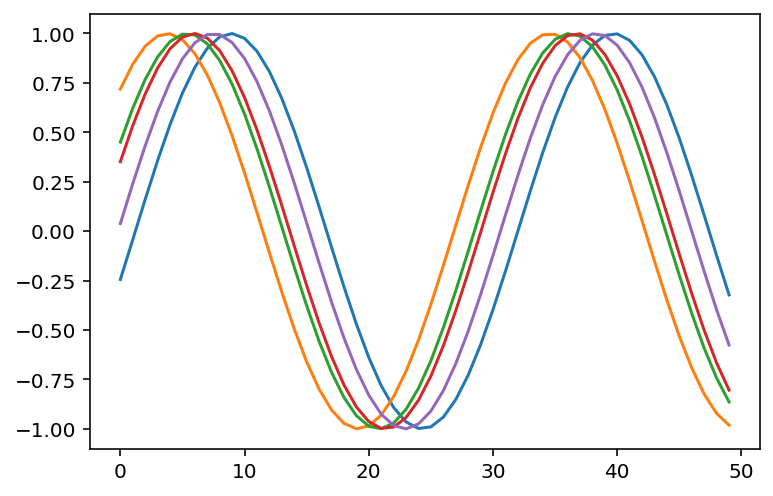

In [14]:
covariance_matrix = np.zeros((5, 5))
variance = 0.5

for i in range(5):
    for j in range(5):
        covariance_matrix[i, j] = 0.9 ** abs(i - j)

covariance_matrix = variance * covariance_matrix

display(covariance_matrix)

np.random.seed(2)
y = np.random.multivariate_normal(np.zeros(5), covariance_matrix)
print(f"{y=}")
angles = np.arcsin(y)
offsets = np.linspace(0, 10)
angles_matrix = angles.reshape(1, -1) + offsets.reshape(-1, 1)
data_matrix = np.sin(angles_matrix)

_ = plt.plot(data_matrix)

In [15]:
x = np.linspace(0, 1, 5)

In [16]:
def get_distance(x1, x2):
    return abs(x1 - x2)

def spatial_graph(lat, data, time):

    # Create an empty graph
    G = nx.Graph()

    for i in range(len(lat)):
        x = lat[i]
        target = data[i]
        G.add_node(i+time, x = x, y = target)
        if i < len(lat)-1:
            G.add_edge(i+time, i+1+time)
    
    return G

In [17]:
def generate_graph(x, data_matrix):
    
    #initialize empty graph
    G = nx.Graph()
    
    #loop over all the timestamps
    for i in range(data_matrix.shape[0]):
        
        #Create Spatial Graph for this timestamp
        G_i = spatial_graph(x, data_matrix[i], i*5)
        
        #Add this graph to the overall graph
        G = nx.compose(G, G_i)
        
        #add temporal edges for each station
        for j in range(len(x)):
            curr_node = i*5 + j

            for time_edge in range(i-1, i-4, -1):
                if time_edge < 0:
                    break
                prev_node = time_edge*5 + j
                G.add_edge(curr_node, prev_node)

        
    return G
        

In [18]:
G = generate_graph(x, data_matrix)

In [19]:
node_features = [[(G.nodes[node]['x'])] for node in G.nodes]

edge_weights = []
undirected_edges = []
for edge in G.edges:
    undirected_edges.append(edge)
    undirected_edges.append((edge[1], edge[0]))  # Add the reverse edge
#     edge_weights.append(G.get_edge_data(edge[0], edge[1])['weight'])
#     edge_weights.append(G.get_edge_data(edge[1], edge[0])['weight'])

edge_index = torch.tensor(undirected_edges).t().contiguous()
edge_weights = torch.tensor(edge_weights).t().contiguous()
y = torch.tensor([G.nodes[node]['y'] for node in G.nodes], dtype=torch.float).view(-1, 1)
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

n_train = int(0.75*len(G.nodes))
n_train -= n_train%5

train_mask[:n_train] = True
test_mask[n_train:] = True

data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, edge_weights = edge_weights, y=y,train_mask=train_mask, test_mask=test_mask).to(device)

In [20]:
class InitialEmbedding(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 8)
        self.linear2 = nn.Linear(8, 4)
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
  

class PredictionLayer(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 10)
        self.linear2 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
        
class MainModel(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.mlp1 = InitialEmbedding(input_dim)
        self.conv1 = GCNConv(4, 8)
        self.conv2 = GCNConv(12, 16)
        self.mlp2 = PredictionLayer(20)
        self.dropout = nn.Dropout(p = 0.5)
        
    def forward(self, x, edge_index):
        #Initial Embedding
        h0 = self.mlp1(x)
        
        #First GCN Layer
        h1 = self.conv1(h0, edge_index)
        h1 = F.relu(h1)
        h1 = self.dropout(h1)
        h1 = torch.cat([h1, h0], dim = 1)
        
        #Second GCN Layer
        h2 = self.conv2(h1, edge_index)
        h2 = F.relu(h2)
        h2 = self.dropout(h2)
        h2 = torch.cat([h2, h0], dim = 1)
        
        #Prediction Layer
        output = self.mlp2(h2)
        
        return output

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:13<00:00, 221.74it/s]


Train RMSE: 0.7001807
Test RMSE: 0.6550073


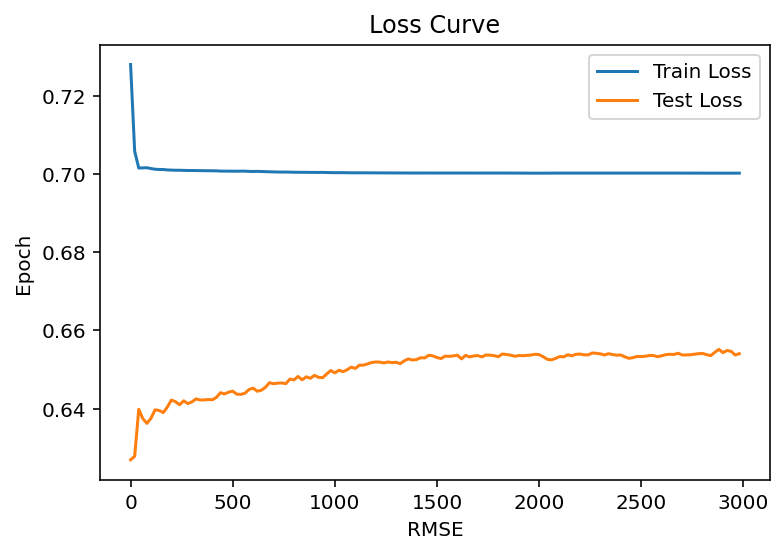

In [21]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MainModel(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(3000)):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print("Train RMSE:", train_rmse.numpy())
    print("Test RMSE:", test_rmse.numpy())

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [22]:
preds = out[data.test_mask].squeeze().detach()
actual = data.y[data.test_mask].squeeze()

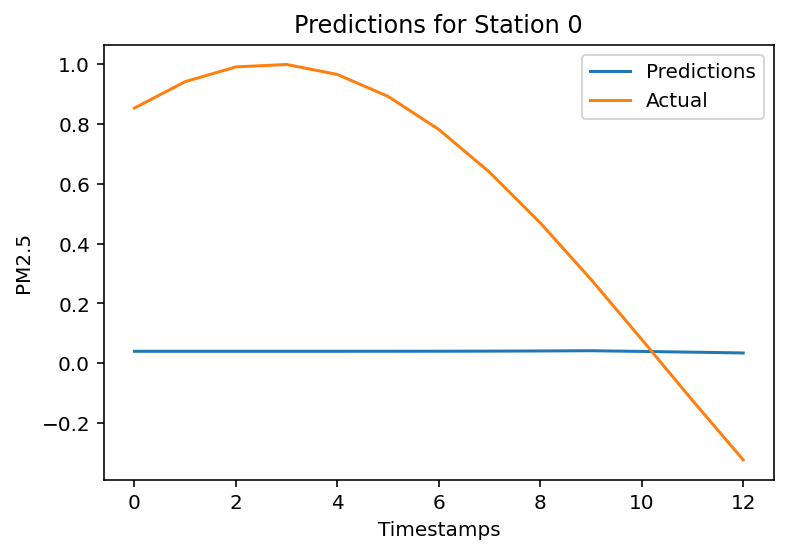

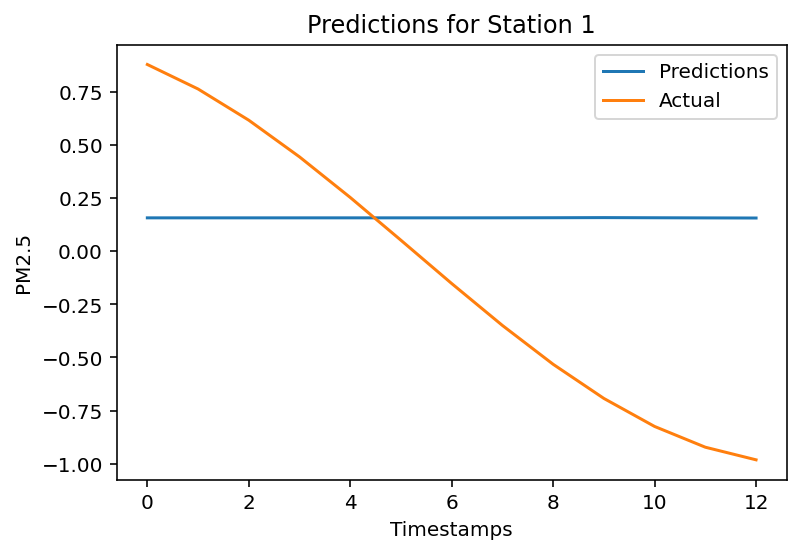

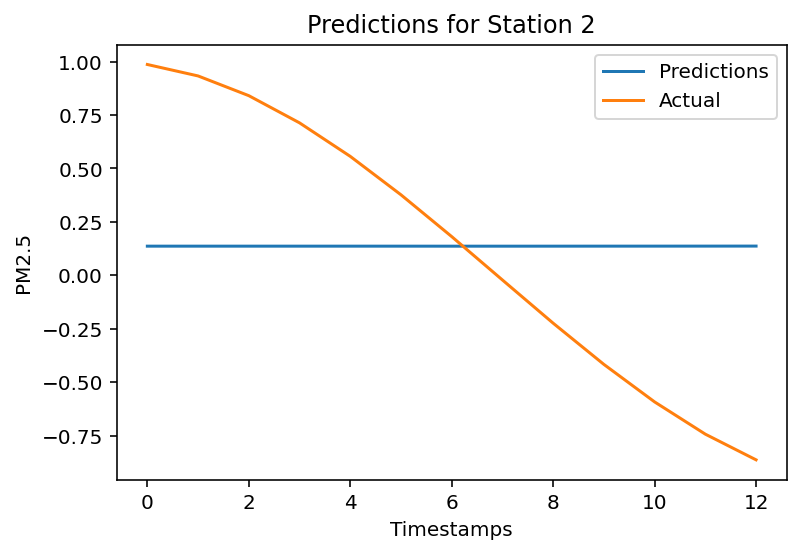

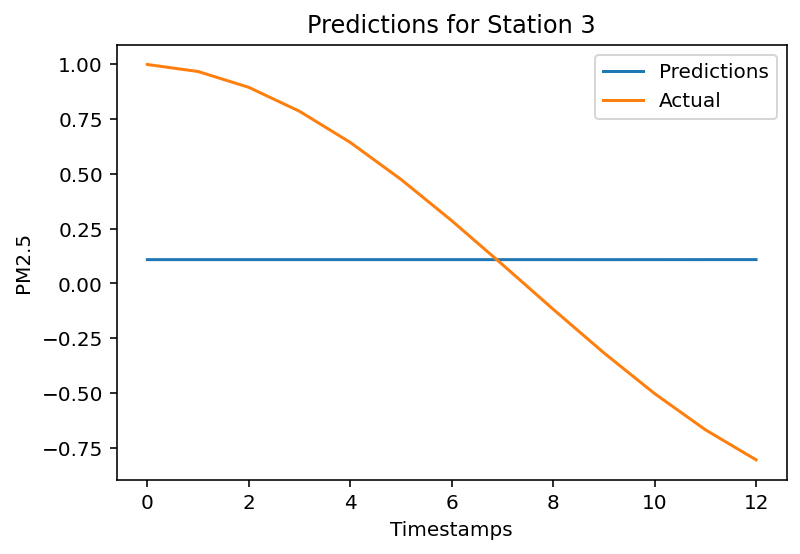

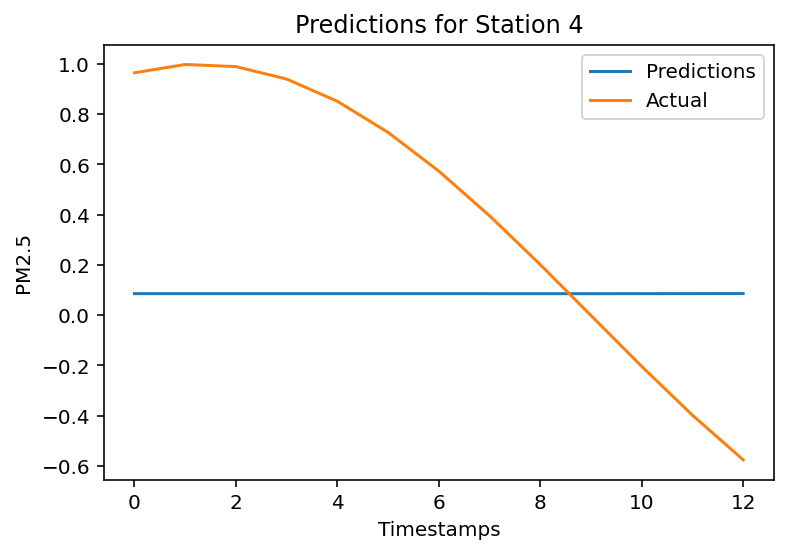

In [23]:
#Dictionaries for storing Predictions and Actual Values station-wise
station_preds = {}
station_actuals = {}

#Initialise empty lists for each station
for i in range(5):
    station_preds[i] = []
    station_actuals[i] = []

#Add predictions and actual values to dictionary
for i in range(0, len(preds), 5):
    for j in range(5):
        station_preds[j].append(preds[i+j])
        station_actuals[j].append(actual[i+j])

#Plot Predictions for Each Station
for i in range(5):
    plt.plot(station_preds[i], label = 'Predictions')
    plt.plot(station_actuals[i], label = 'Actual')
    plt.xlabel('Timestamps')
    plt.ylabel('PM2.5')
    plt.legend()
    title = 'Predictions for Station ' + str(i)
    plt.title(title)
    plt.show()

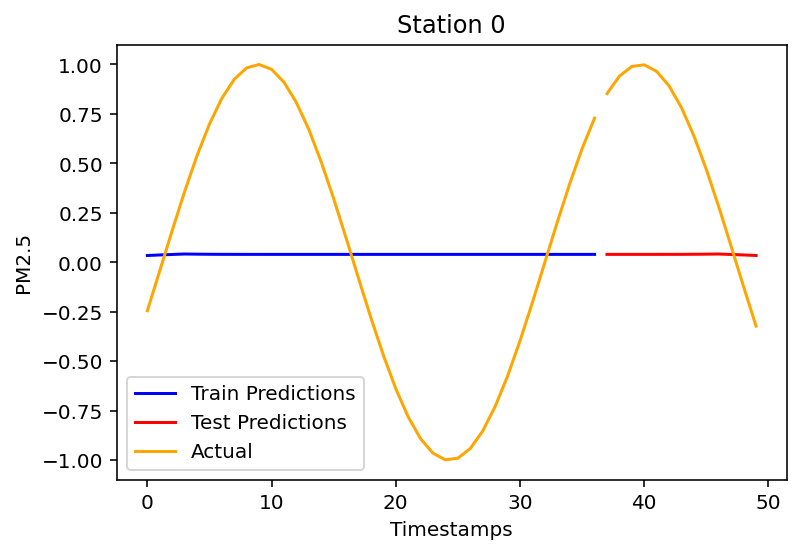

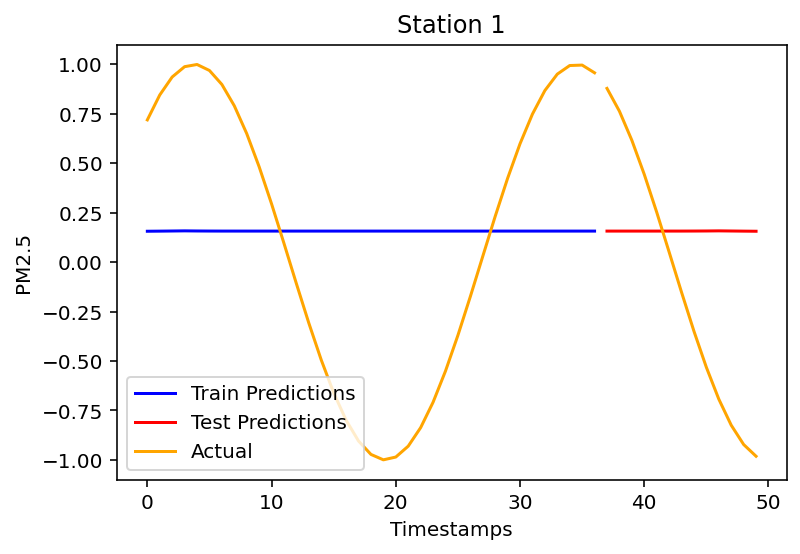

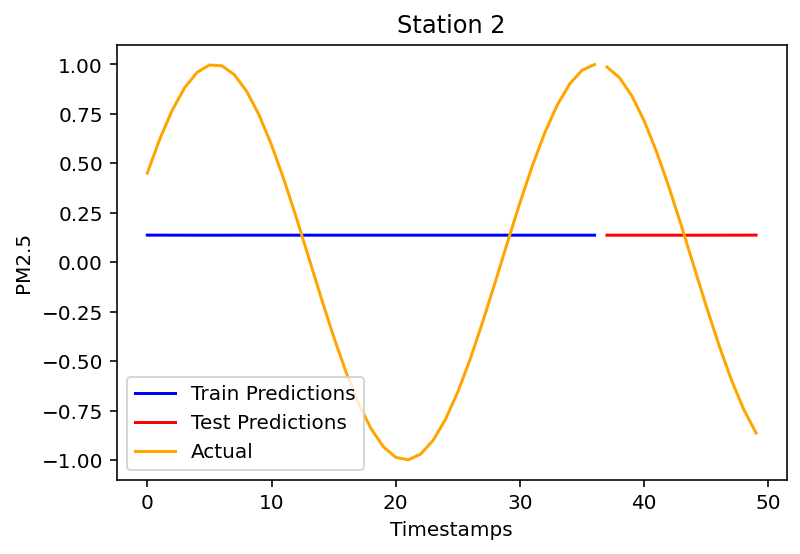

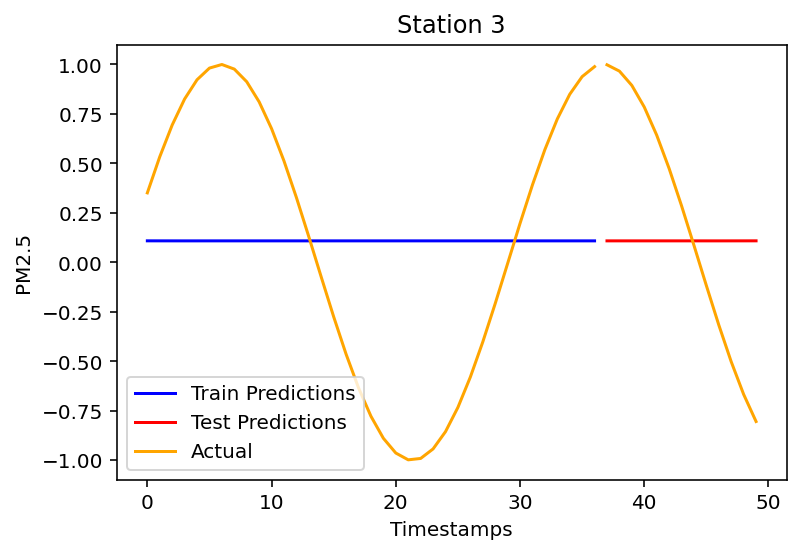

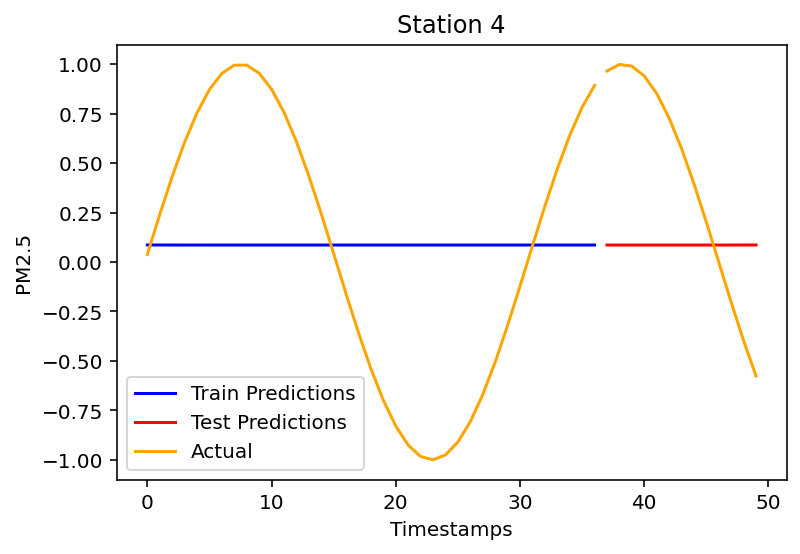

In [24]:
train_preds = out[data.train_mask].squeeze().detach()
train_actual = data.y[data.train_mask].squeeze()

train_stationwise_preds = {}
actual_stationwise_values = {}

for i in range(5):
    train_stationwise_preds[i] = []
    actual_stationwise_values[i] = []

for i in range(0, len(train_preds), 5):
    for j in range(5):
        train_stationwise_preds[j].append(train_preds[i+j])
        actual_stationwise_values[j].append(train_actual[i+j])

# Number of Timestamps in Training Data
n_ts = n_train//5

for i in range(5):
    plt.plot(range(n_ts), train_stationwise_preds[i], label = 'Train Predictions', color = 'blue')
    plt.plot(range(n_ts, n_ts+len(station_actuals[0])), station_preds[i], label = 'Test Predictions', color = 'red')
    plt.plot(range(n_ts), actual_stationwise_values[i], label = 'Actual', color = 'orange')
    plt.plot(range(n_ts, n_ts+len(station_actuals[0])), station_actuals[i], color = 'orange')
    plt.xlabel('Timestamps')
    plt.ylabel('PM2.5')
    plt.legend()
    title = 'Station ' + str(i)
    plt.title(title)
    plt.show()